In [1]:
import os 
os.chdir('/u/duvel-d2/govorcin/NJ/ASC/GNSS')

In [1]:
import sys
from pathlib import Path

venti_src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src')
sys.path.append(str(venti_src_path))

In [6]:
# Load needed modules
import os
import itertools
import numpy as np
import scipy.stats as stats
from pathlib import Path

# Dataframe
import pandas as pd
import geopandas as gpd

# Ploting 
from matplotlib import pyplot as plt
import contextily as cx
from xyzservices import TileProvider

# Geometry
import pyproj
from shapely.geometry import box

# Plate motion, GNSS, LSC interpolation
from venti.gnss.euler import rotation_rate2euler_pole, get_local_frame
from venti.gnss.gps import UNR
from venti.gnss.interpolation import hvlsc

In [12]:
%load_ext autoreload
%autoreload 2

## Functions

In [88]:
def _get_sigmas(data: np.ndarray, add_mean=True):
    sigma1 = (np.percentile(data, 50+34.1, axis=0)- np.percentile(data, 50-34.1, axis=0))/2.
    sigma2 = (np.percentile(data, 50+34.1+13.6, axis=0)- np.percentile(data, 50-34.1-13.6, axis=0))/2.
    sigma3 = (np.percentile(data, 50+34.1+13.6+2.1, axis=0)- np.percentile(data, 50-34.1-13.6-2.1, axis=0))/2
    
    # Get mean + sigma 1, 2, 3
    if add_mean:
        sigma1 += np.nanmean(data)
        sigma2 += np.nanmean(data)
        sigma3 += np.nanmean(data)
    return sigma1, sigma2, sigma3

# Plotting
url = {'hillshade': 'http://services.arcgisonline.com/arcgis/rest/services/Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}.png',
       'dark': 'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}',
       'places':'https://server.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}'}

esri = lambda x: TileProvider(name='ESRI',url=x, attribution='')

def _add_basemap(ax, zorder=0, alpha=1, zoom=5, source='hillshade'):
    ''' Add ESRI basemap to figure'''
    if source == 'gray_canvas':
        source = cx.providers.Esri.WorldGrayCanvas
    else:
        source = esri(url[source])

    cx.add_basemap(ax,
                   zorder=zorder,
                   source=source ,
                   crs='EPSG:4326',
                   alpha=alpha,
                   zoom=zoom)#,
                   #cmap='gray')
    

### PLOT GNSS
def _plot_gnss(df,
            column_list=['e','n','v'],
            cmap_list=['jet', 'jet', 'jet'],
            clim_list=[[-35, 10], [-30, 10], [-10, 10]],
            prefix_title='',
            states=None,
            faults=None,
            scatter_kwargs=None,
            **kwargs):

    # Figure
    fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
    scatter_kwargs = dict(edgecolor='white', lw=0.3, markersize=10, zorder=1)
    cb_kwargs = dict(location='bottom', pad=0.05, extend='both', label='[mm/yr]')
    cb_kwargs = {**cb_kwargs, **kwargs}

    # Title
    txt = [f'{prefix_title} East-West',
            f'{prefix_title} North-South',
            f'{prefix_title} Up-Down']

    for ix, (column, clim, cmap, t) in enumerate(zip(column_list,
                                                    clim_list,
                                                    cmap_list,
                                                    txt)):
        # plot
        im = df.plot(ax=ax[ix], column=column,
                            vmin=clim[0], vmax=clim[1],
                            cmap=cmap, **scatter_kwargs)
        # Colorbar
        fig.colorbar(im.collections[0], ax=ax[ix].axes, **cb_kwargs)

        # Title
        ax[ix].set_title(t)

        # Basemap
        _add_basemap(ax[ix], 0, alpha=1, zoom=6, source='hillshade')
        _add_basemap(ax[ix], 0, alpha=0.7, zoom=6, source='gray_canvas') 

        # Auxiliary
        if states is not None: states.plot(ax=ax[ix], lw=0.1, color='none',zorder=2)
        if faults is not None: faults.plot(ax=ax[ix], color='darkslategrey', lw=1.5)

        # Format tick labels
        ax[ix].xaxis.set_major_formatter('{x:.0f}°W')
        ax[ix].yaxis.set_major_formatter('{x:.0f}°N')
    return fig, ax


def _find_utm_zone(snwe:list):
    utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=pyproj.aoi.AreaOfInterest(
        west_lon_degree=snwe[2],
        south_lat_degree=snwe[0],
        east_lon_degree=snwe[3],
        north_lat_degree=snwe[1],),
    )
    return pyproj.CRS.from_epsg(utm_crs_list[0].code)

def _get_buffer_around_fault(fault_df, distance, utm_crs):
    'Distance in meters'
    fault = fault_df.to_crs(utm_crs)
    buffer = fault.buffer(distance)
    return buffer.to_crs(4326)

def _filter_grid_points(grid_df, type='sites'):
    return grid_df[grid_df['grid_type']==type]

def predict_plate_motion(lon, lat, wx, wy, wz):

    W = np.vstack([wx, wy, wz])
    # deg/My 2 rad/My
    W = np.radians(W) 
    Rx = list(map(get_local_frame, lon, lat))
    prediction = np.hstack(list(map(np.dot, Rx, itertools.repeat(W, len(Rx))))).T
    return prediction

##### COLLOCATION
def collocation2grid(input_lon, input_lat,
                     grid_lon, grid_lat, 
                     data, cov_inverse, 
                     function_parameters,
                     max_points=2000,
                     movvar_parameters=[1, 850, None, 7],
                     moving_variance=False,
                     iteration_order=['ee', 'en', 'ne', 'nn']):
    
    ### This part can be done in segments (easy to parallize)
    num_elements = grid_lon.shape[0]
    itemsize = grid_lon.itemsize
    n_rows = np.int32((np.ceil(num_elements) // max_points) + 1)
    extra = np.abs(num_elements - n_rows * max_points)

    # Output
    new_shape = (n_rows, max_points)
    stride_steps_row = itemsize * max_points
    stride_steps_col = itemsize
    stride_steps = (stride_steps_row, stride_steps_col)

    # Create subsets
    xe = np.lib.stride_tricks.as_strided(grid_lon, new_shape, stride_steps)
    ye = np.lib.stride_tricks.as_strided(grid_lat, new_shape, stride_steps)

    # Use dask or multiprocessing/joblib to parallize
    signal_xiyi, signal_xiyi_error = [], []

    collocation_param = dict(x=input_lon, y=input_lat,
                             obs=data, C_inv=cov_inverse, 
                             xi=None, yi=None,
                             empirical_fparameters=function_parameters,
                             movvar_parameters=movvar_parameters,
                             moving_variance=moving_variance,
                             iteration_order=iteration_order)

    for ix, (xi, yi) in enumerate(zip(xe,ye)):
        print(f'Loop {ix+1}')
        if ix == (n_rows - 1):
            # Clip the extra values in the last loop
            xi = xi[:-extra]
            yi = yi[:-extra] 
        subset_dict = dict(xi=xi,yi=yi)
        s_xiyi, s_xiyi_error = hvlsc.collocation.calc_signal_xiyi(**{**collocation_param, **subset_dict})
        signal_xiyi.append(s_xiyi)
        signal_xiyi_error.append(s_xiyi_error)

    # Reshape
    signal_xiyi = np.vstack(signal_xiyi)
    signal_xiyi_error = np.vstack(signal_xiyi_error)
    return signal_xiyi, signal_xiyi_error


# Load Data

In [52]:
# Setup
work_dir = Path('/u/duvel-d2/govorcin/NJ/ASC/GNSS/2015_2024')

# AOI: Houston
aoi = box(-90, 26, -65,  45)

# UTM zone
utm_crs = _find_utm_zone([26, 33, -103, -89])

In [53]:
# Load auxiliary data
states = gpd.read_file('zip:///u/trappist-r0/govorcin/06_PAPERS/VLM_CA/05_Figures/tl_2023_us_state.zip', crs='EPSG:4326')

# simplified fualts with fault slip greater than 5 mm/yr
#faults = gpd.read_file('zip:///u/trappist-r0/govorcin/06_PAPERS/VLM_CA/05_Figures/ca_faults.zip')

# Ocean
ocean = gpd.read_file('/u/trappist-r0/govorcin/06_PAPERS/VLM_CA/05_Figures/ne_10m_ocean/ne_10m_ocean.shp')
#ocean = ocean.clip(aoi)

## Load tectonic plates: Bird et al 2003
plates = gpd.read_file('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/data/plates/PB2002_plates.json')
plates.set_crs('EPSG:4326')
plates = plates.clip(aoi)

In [54]:
# Load stored GNSS velocities
gnss_pickle = 'unr_gnss_midas_2015_2024.pickle'

# Initialize UNR class
gnss = UNR(output_dir=str(work_dir))
gnss = gnss.load(gnss_pickle)

gnss_points = gpd.points_from_xy(gnss.gnss_df.lon,
                                 gnss.gnss_df.lat)

# Get geoDataframe
gnss_df = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gnss_points,
                           crs='EPSG:4326')

# Remove site outside of aoi
#gnss_df = gnss_df.clip(aoi)
print(f' Number of GNSS sites: {gnss_df.shape[0]}')

/u/duvel-d2/govorcin/NJ/ASC/GNSS/2015_2024/unr_gnss_midas_2015_2024.pickle.pkl
 Number of GNSS sites: 411


## Preprocesing: filter GNSS data for interpolation

In [55]:
# 1. Drop the GNSS site sharing same location to avoid bias in estimation of empirical covariance
drop_ix = [1]
same_points = []
while len(drop_ix) > 0:
    for i, (_, ip) in enumerate(gnss_df.iterrows()):
        if np.sum(gnss_df.geom_equals(ip.geometry)) > 1:
            same_df = gnss_df[gnss_df.geom_equals(ip.geometry)].copy()
            # Drop the shorter one
            if same_df.duration.unique().shape[0] > 1:
                flag = same_df[same_df.duration == same_df.duration.min()]
            else:
                # Drop the one with more gaps
                flag = same_df[same_df.gap_percentage == same_df.gap_percentage.max()]
            same_points.append(flag.index)
    drop_ix = np.unique(same_points)
    print(gnss_df[gnss_df.index.isin(drop_ix)].site.values)
    
    # Remove it from dataframe
    if gnss_df.index.isin(drop_ix).any():
        gnss_df = gnss_df.drop(drop_ix, axis=0)
    else:
        # If sites are not in dataframe, stop while loop
        drop_ix = []

[]


In [56]:
# Get basics stats

print('Velocity')
print(50*'-')
print(f'EW: {gnss_df.e.mean():.2f}', u"\u00B1", f'{gnss_df.e.std():.2f} mm/yr')
print(f'NS: {gnss_df.n.mean():.2f}', u"\u00B1", f'{gnss_df.n.std():.2f} mm/yr')
print(f'UD: {gnss_df.v.mean():.2f}', u"\u00B1", f'{gnss_df.v.std():.2f} mm/yr')
print(50*'-')

print('Velocity Std')
print(50*'-')
print(f'EW: {gnss_df.se.mean():.2f}', u"\u00B1", f'{gnss_df.se.std():.2f} mm/yr')
print(f'NS: {gnss_df.sn.mean():.2f}', u"\u00B1", f'{gnss_df.sn.std():.2f} mm/yr')
print(f'UD: {gnss_df.sv.mean():.2f}', u"\u00B1", f'{gnss_df.sv.std():.2f} mm/yr')
print(50*'-')

print('Temporal. Variability Index')
print(50*'-')
print(f'dEv: {gnss_df.dEv.mean():.2f}', u"\u00B1", f'{gnss_df.dEv.std():.2f} mm/yr')
print(f'dNv: {gnss_df.dNv.mean():.2f}', u"\u00B1", f'{gnss_df.dNv.std():.2f} mm/yr')
print(f'dVv: {gnss_df.dVv.mean():.2f}', u"\u00B1", f'{gnss_df.dVv.std():.2f} mm/yr')
print(50*'-')

Velocity
--------------------------------------------------
EW: -14.97 ± 0.97 mm/yr
NS: 4.19 ± 0.96 mm/yr
UD: -0.75 ± 1.16 mm/yr
--------------------------------------------------
Velocity Std
--------------------------------------------------
EW: 0.24 ± 0.16 mm/yr
NS: 0.24 ± 0.09 mm/yr
UD: 0.74 ± 0.11 mm/yr
--------------------------------------------------
Temporal. Variability Index
--------------------------------------------------
dEv: 0.27 ± 0.56 mm/yr
dNv: 0.28 ± 0.25 mm/yr
dVv: 0.92 ± 0.65 mm/yr
--------------------------------------------------


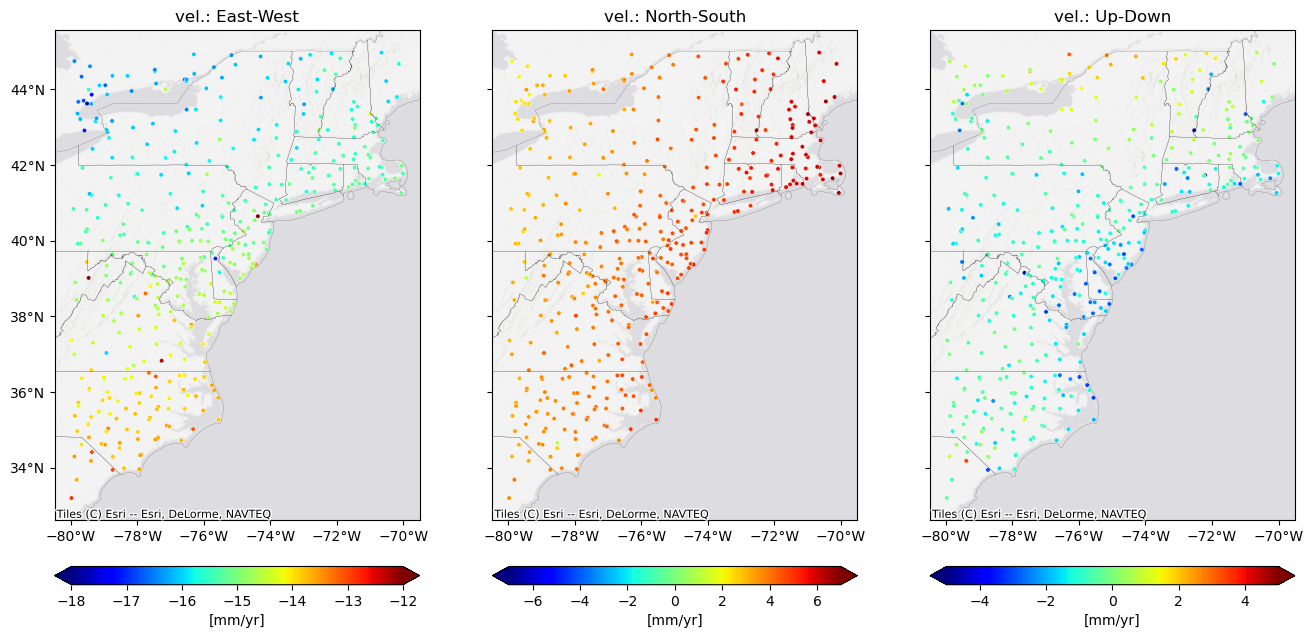

In [57]:
aux = dict(states=states)
_ = _plot_gnss(gnss_df, prefix_title='vel.:',
               clim_list=[[-18, -12], [-7, 7], [-5, 5]],
               **aux)

In [58]:
gnss_df.keys()

Index(['site', 'lat', 'lon', 'n', 'e', 'v', 'sn', 'se', 'sv', 'n_gaps',
       'duration', 'start_date', 'end_date', 'ts_path', 'gap_percentage',
       'dEv', 'dNv', 'dVv', 'geometry', 'spatial_var_v_rms',
       'spatial_var_v_mad', 'spatial_var_e_rms', 'spatial_var_e_mad',
       'spatial_var_n_rms', 'spatial_var_n_mad', 'ssf_v', 'ssf_e', 'ssf_n',
       'ssf_npoints', 'dmin', 'dmax', 'dmean', 'dmedian', 'npoints'],
      dtype='object')

"\n_ =_plot_gnss(gnss_df,\n              prefix_title='abs MIDAS-HECTOR:',\n              column_list=['midas_hector_e','midas_hector_n','midas_hector_v'],\n              cmap_list=['gist_heat_r', 'gist_heat_r', 'gist_heat_r'],\n              clim_list=[[0, 3], [0, 3], [0, 3]],\n              extend='max',\n              label='mm/yr',\n              **aux)\n"

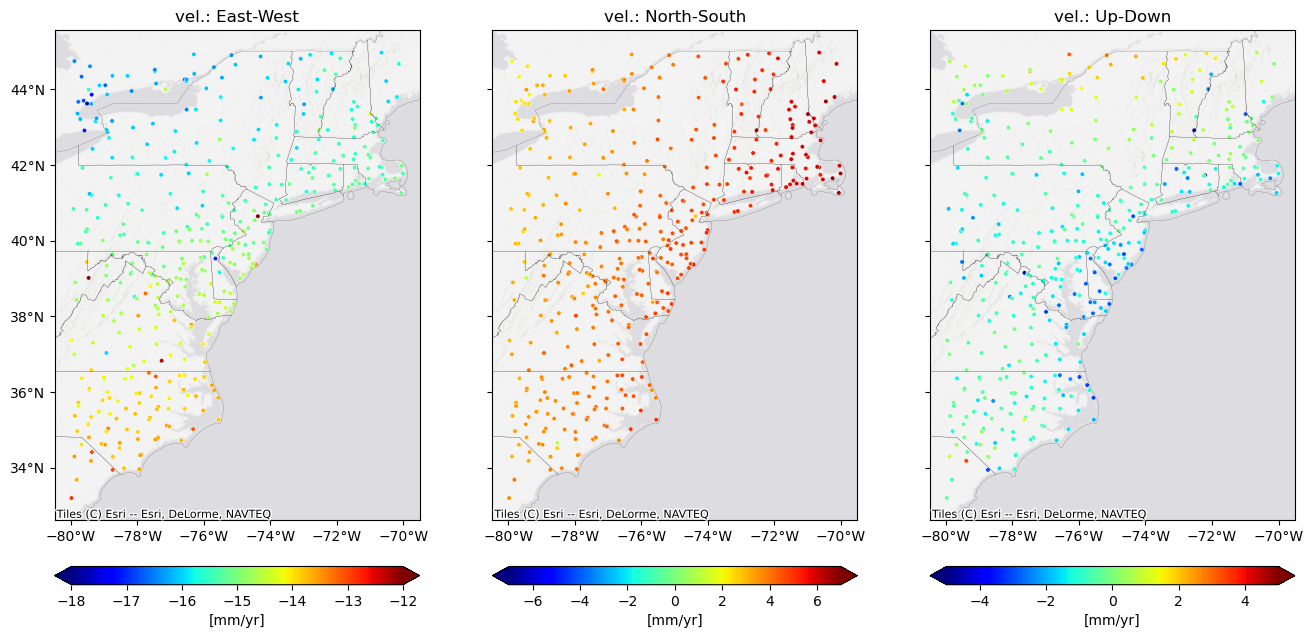

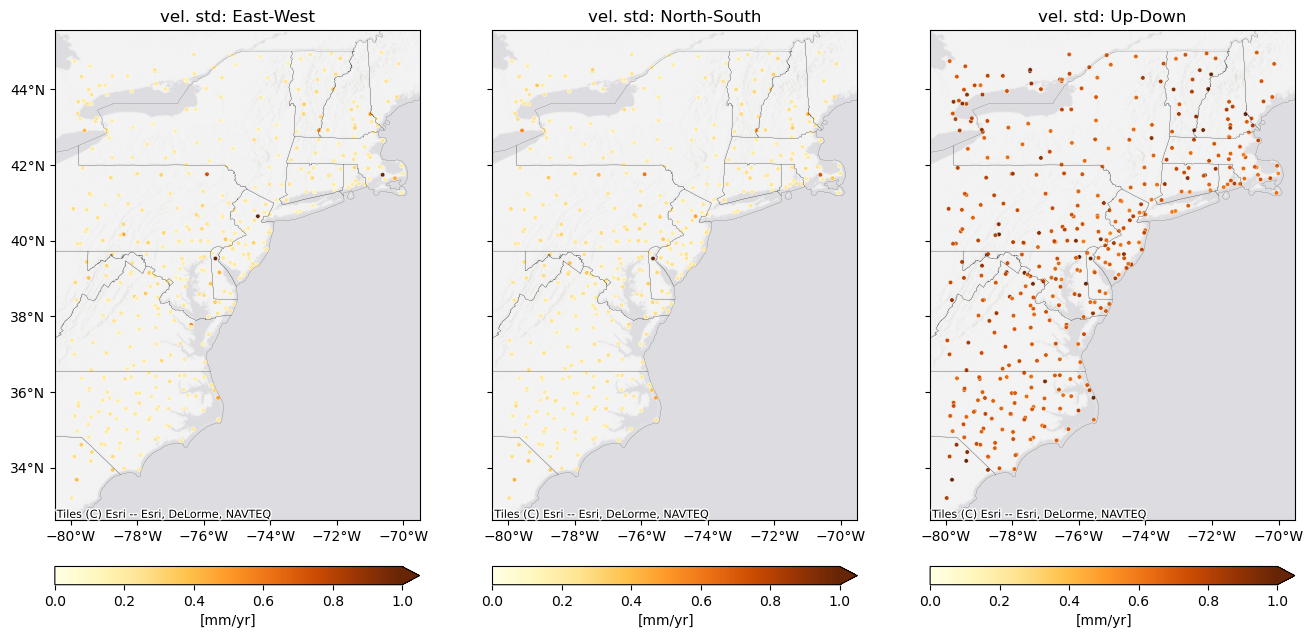

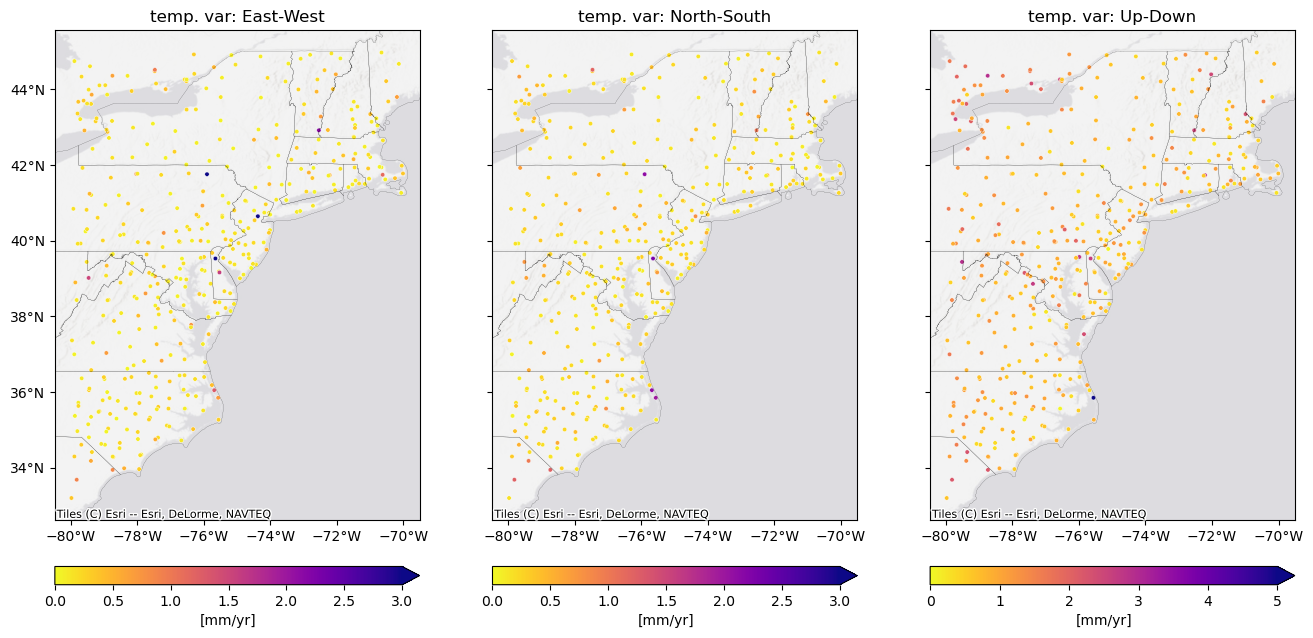

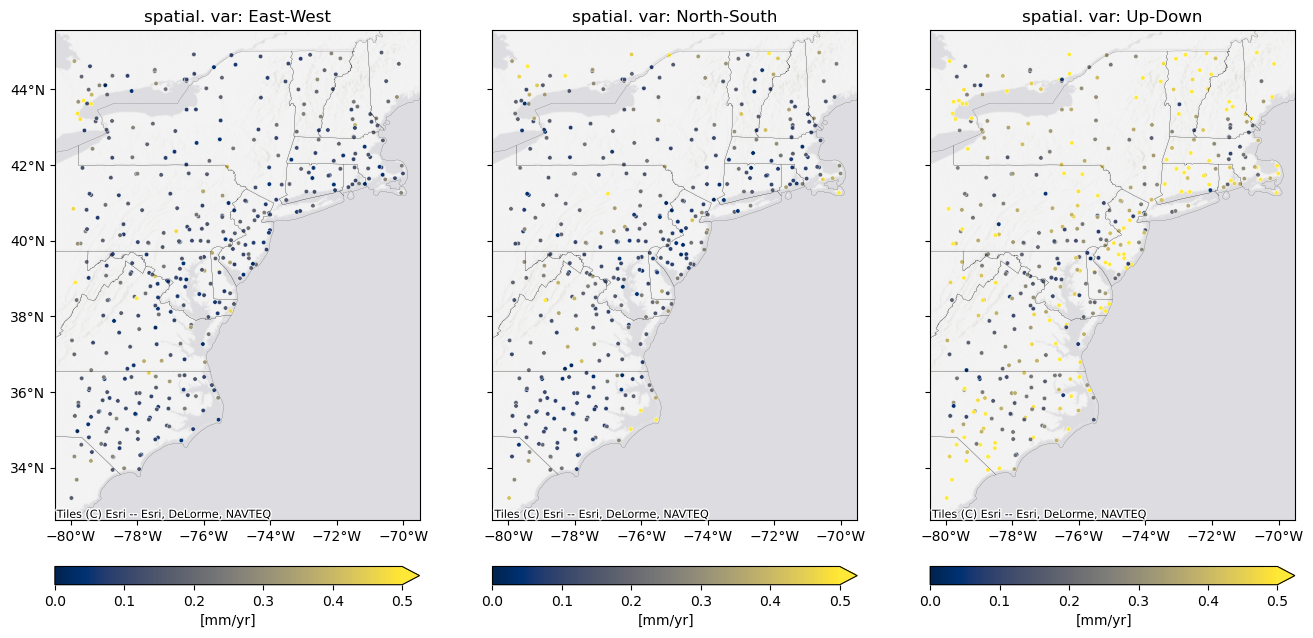

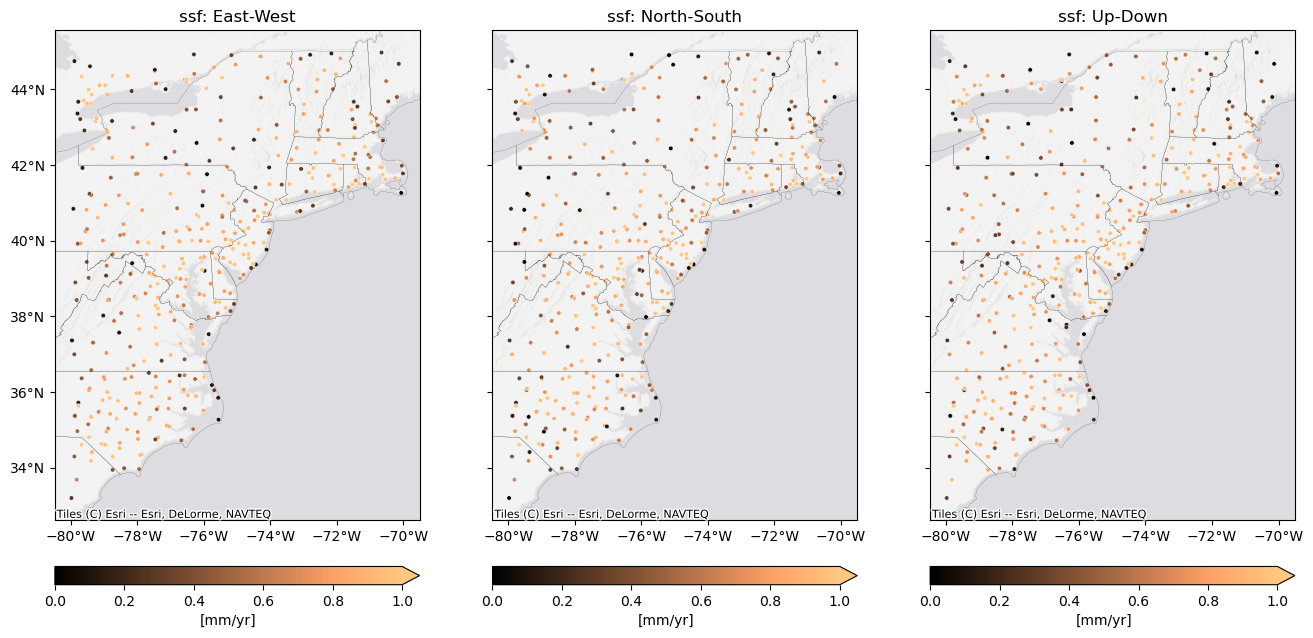

In [59]:
# PLOT GNSS velocities, velocityStd, and Temporal Variability Index
aux = dict(states=states)

# EW, NS, U : Velocity
_ = _plot_gnss(gnss_df, prefix_title='vel.:',
               clim_list=[[-18, -12], [-7, 7], [-5, 5]],
               **aux)

# EW, NS, U : VelocityStd
_ =_plot_gnss(gnss_df,
              prefix_title='vel. std:',
              column_list=['se','sn','sv'],
              cmap_list=['YlOrBr', 'YlOrBr', 'YlOrBr'],
              clim_list=[[0, 1], [0, 1], [0, 1]],
              extend='max',
              **aux)

# EW, NS, U : Temporal Variability
_ =_plot_gnss(gnss_df,
              prefix_title='temp. var:',
              column_list=['dEv','dNv','dVv'],
              cmap_list=['plasma_r', 'plasma_r', 'plasma_r'],
              clim_list=[[0, 3], [0, 3], [0, 5]],
              extend='max',
              **aux)

# EW, NS, U : Spatial Variability
_ =_plot_gnss(gnss_df,
              prefix_title='spatial. var:',
              column_list=['spatial_var_e_mad','spatial_var_n_mad','spatial_var_v_mad'],
              cmap_list=['cividis', 'cividis', 'cividis'],
              clim_list=[[0, 0.5], [0, 0.5], [0, 0.5]],
              extend='max',
              **aux)

# EW, NS, U : SSF
_ =_plot_gnss(gnss_df,
              prefix_title='ssf:',
              column_list=['ssf_e','ssf_n','ssf_v'],
              cmap_list=['copper', 'copper', 'copper'],
              clim_list=[[0, 1], [0, 1], [0, 1]],
              extend='max',
              **aux)

# EW, NS, U : MIDAS/HECTOR
'''
_ =_plot_gnss(gnss_df,
              prefix_title='abs MIDAS-HECTOR:',
              column_list=['midas_hector_e','midas_hector_n','midas_hector_v'],
              cmap_list=['gist_heat_r', 'gist_heat_r', 'gist_heat_r'],
              clim_list=[[0, 3], [0, 3], [0, 3]],
              extend='max',
              label='mm/yr',
              **aux)
'''

In [60]:
# Choose only stable sites using:
print(f'Number of GNSS sites: {gnss_df.shape[0]}')
print(50*'-')
# 1. temporal variability < 1sigma
print('Remove sites with temp. var. index above its 1sigma')
gnss_df2 = gnss_df.drop(gnss_df[gnss_df.dVv > _get_sigmas(gnss_df.dVv)[1]].index, axis=0)
gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.dNv > _get_sigmas(gnss_df.dNv)[1]].index, axis=0)
gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.dEv > _get_sigmas(gnss_df.dEv)[1]].index, axis=0)
print(f'Number of kept sites: {gnss_df2.shape[0]}')

# 2. Absolute difference between MIDAS and HECTOR > 1mm/yr
th = 1
#print(f'Remove sites with abs difference between Hector and MIDAS > {th} mm/yr')
#gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.midas_hector_e > th].index, axis=0)
#gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.midas_hector_n > th].index, axis=0)
#gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.midas_hector_v > th].index, axis=0)
#print(f'Number of kept sites: {gnss_df2.shape[0]}')

# 3. SSF < 0.6
th = 0.3
print(f'Remove sites with SSF < {th} with it neighboring sites')
gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.ssf_e < th].index, axis=0)
gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.ssf_n < th].index, axis=0)
gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.ssf_v < th].index, axis=0)
print(f'Number of kept sites: {gnss_df2.shape[0]}')

# 4. 3D vel. std. < 1sigma
print('Remove sites with 3d vel. std above its 1sigma')
vel_3d_std = np.sqrt(gnss_df2.se**2 + gnss_df2.sn**2 + gnss_df2.sv**2)
gnss_df2 = gnss_df2.drop(gnss_df2[vel_3d_std > _get_sigmas(vel_3d_std)[1]].index, axis=0)
print(f'Number of kept sites: {gnss_df2.shape[0]}')



# 4. Sites with localized absolute vertical rate above 1.5 mm/yr but avoid Cascadia zone
#th = 10
#print(f'Remove sites with absolute vertical rate above its {th} mm/yr')
#area_df = gnss_df2[gnss_df2.within(box(-122.5, 31.5, -112,  42))]
#drop_ix = area_df[area_df.v.abs() > th].index
#drop_ix = gnss_df2[gnss_df2.v.abs() > th].index
#gnss_df2 = gnss_df2.drop(drop_ix, axis=0)
#print(f'Number of kept sites: {gnss_df2.shape[0]}')

# 5. Remove major faults(>5mm/yr slip rate) near-field GNSS sites due to creeping 
#distance = 5 # km
#print(f'Remove sites within {distance} km distance around major fault system')
#near_field = _get_buffer_around_fault(faults, distance*1e3, utm_crs)

# Remove points near the fault
#for ix, segment in enumerate(near_field):
#    if segment != None:
#        gnss_df2 = gnss_df2.drop(gnss_df2[gnss_df2.within(near_field[ix])].index)
#print(f'Number of kept sites: {gnss_df2.shape[0]}')

Number of GNSS sites: 411
--------------------------------------------------
Remove sites with temp. var. index above its 1sigma
Number of kept sites: 373
Remove sites with SSF < 0.3 with it neighboring sites
Number of kept sites: 278
Remove sites with 3d vel. std above its 1sigma
Number of kept sites: 262


In [61]:
# EW, NS, U : Velocity
flag = gnss_df.site.isin(gnss_df2.site)
fig, ax = _plot_gnss(gnss_df2,
                     clim_list=[[-18, -12], [-7, 7], [-5, 5]],
                     prefix_title='vel.:', **aux)
for a in ax:
    # Show removed sites
    a.plot(gnss_df.lon[~flag], gnss_df.lat[~flag],'o',
           color='black', markersize=1, alpha=0.7, label = ('Dropped GNSS sites'))
    
    # Show buffer around fault system
    #near_field.plot(ax=a, alpha=0.1, color='tomato')
    a.legend()

## Prepare interpolation grid

In [62]:
# Get central coordinatal of obs extent and dimensions
lon0, lat0, extent_width, extent_height = hvlsc.grid.get_obs_lalon0_extent(gnss_df2.lon, gnss_df2.lat)
print(f' Central latitude: {lat0} | Central longitude {lon0}')
print(f' Rounded max distance from min to max latitude: {extent_height} km')
print(f' Rounded max distance from min to max longitude: {extent_width} km')
print(50*'#')

# Get regular grid for interpolation with spacing 30 km
grid_lons, grid_lats = hvlsc.grid.create_regular_grid(lon0, lat0,
                                                      extent_width, extent_height,
                                                      dx=50, dy=50,
                                                      buffer_x=100*3, buffer_y=100*2,
                                                      unit='km')

del lon0, lat0, extent_height, extent_width

# Clip grid
grid_points = gpd.points_from_xy(grid_lons.ravel(),
                                 grid_lats.ravel())
# Init grid dataframe
grid_df = gpd.GeoDataFrame([], geometry = grid_points, crs='EPSG:4326')

# clip 
grid_df = grid_df[grid_df.within(aoi)]

# Get lats, lons
grid_df['lons'] = grid_df.geometry.apply(lambda x: np.squeeze(x.xy[0]))
grid_df['lats'] = grid_df.geometry.apply(lambda x: np.squeeze(x.xy[1]))

 Central latitude: 39.4 | Central longitude -75.2
 Rounded max distance from min to max latitude: 1300.0 km
 Rounded max distance from min to max longitude: 820.0 km
##################################################


In [63]:
#grid_df = grid_df.from_file('clean_grid')
grid_df['lons'] = grid_df.geometry.apply(lambda x: np.squeeze(x.xy[0]))
grid_df['lats'] = grid_df.geometry.apply(lambda x: np.squeeze(x.xy[1]))

In [64]:
# Place boundry constrain: Separate interpolation and input points by 1500km
flag = [gnss_df2.within(plate.geometry).any() for _, plate in plates.iterrows()]
plates = plates[flag].reset_index(drop=True)

# Separate
ix = 0 # cental plate index, set to NA
dist = 0 # km, distance for plate separation
print(f'Central plate: {plates.loc[ix].Code}')
mov_df = hvlsc.move_plates.change_coords_plate(gnss_df2, 
                                               grid_df.lons.values,
                                               grid_df.lats.values,
                                               plates, dist, 
                                               central_ix=ix)

# Plot grid and data
fig, ax = plt.subplots(1)
ax.plot(_filter_grid_points(mov_df,'grid').mov_lon,
        _filter_grid_points(mov_df,'grid').mov_lat, 
        'r.', ms=1, label='moved_grid', alpha=0.2)

ax.plot(_filter_grid_points(mov_df,'sites').mov_lon,
        _filter_grid_points(mov_df,'sites').mov_lat,
        'g.', ms=2, label='moved_sites', alpha=0.8)

mov_df.plot(ax=ax,  marker='.', markersize=0.1, label='grid')
ax.plot(gnss_df2.lon, gnss_df2.lat,'o', markersize=4, color='orange')
plates.exterior.plot(ax=ax, color='black', alpha=0.3)

ax.set_ylabel('Latitude [deg]')
ax.set_xlabel('Longitude [deg]')
ax.legend()

plates.head()

Central plate: NA
0
0 0
Work again
ix1 ix2 Distance


LAYER Code      PlateName  \
0  plate   NA  North America   

                                            geometry  
0  POLYGON ((-90.00000 26.00000, -90.00000 45.000...

### Remove plate motion for NA and PA

In [66]:
# Read plate angular velocities specified in ITRF2014-PMM
code2itrf = {'NA' : 'NOAM'}

# Load Absolute plate rotation poles defining ITRF2014-PMM
names = ['code', 'omega_x', 'omega_y', 'omega_z']
plate_motion =pd.read_csv('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/data/plates/itrf2014_plates.txt',
                          skiprows=5, delimiter=r"\s+", names=names)

# Add columns for plate motion
mov_df['plate_ew'] = np.NaN
mov_df['plate_ns'] = np.NaN
mov_df['plate_up'] = np.NaN

# Find sites and grid points within each plate
gnss_df2['plate'] = None
for _, plate in plates.iterrows():
    sites = gnss_df2[gnss_df2.within(plate.geometry)].site
    gnss_df2.loc[gnss_df2.site.isin(sites), 'plate'] = plate.Code
    
print(f'GNSS sites cover: {list(gnss_df2.plate.unique())} plates')

GNSS sites cover: ['NA'] plates


In [124]:
option = 1

if option==1:
    # Option 1: Relative to North America
    plate_omegas = plate_motion[plate_motion.code == code2itrf['NA']]
    print('NA', plate_omegas)

    plate_v = predict_plate_motion(mov_df.lon.values, 
                                mov_df.lat.values,
                                plate_omegas.omega_x, 
                                plate_omegas.omega_y, 
                                plate_omegas.omega_z)
                    
    mov_df['plate_ew'] = np.float64(plate_v)[:,0]
    mov_df['plate_ns'] = np.float64(plate_v)[:,1]
    mov_df['plate_up'] = np.float64(plate_v)[:,2]

elif option==2:
    # Option 2. Remove both NORTH AMERICA & PACIFIC plate motion
    for p in ['NA', 'PA']:
        plate_gnss = mov_df[mov_df.Code == p]
        plate_omegas = plate_motion[plate_motion.code == code2itrf[p]]
        print(p, plate_omegas)

        plate_v = predict_plate_motion(plate_gnss.lon.values, 
                                    plate_gnss.lat.values,
                                    plate_omegas.omega_x, 
                                    plate_omegas.omega_y, 
                                    plate_omegas.omega_z)
                        
        mov_df.loc[mov_df.Code == p,
                ['plate_ew', 'plate_ns', 'plate_up']] = np.float64(plate_v)
else:
    print('No plate motion correction')
    mov_df['plate_ew'] = np.zeros_like(mov_df.e.values)
    mov_df['plate_ns'] = np.zeros_like(mov_df.e.values) 
    mov_df['plate_up'] = np.zeros_like(mov_df.e.values)


# Get residuals between displacments and model values
mov_df['res_e'] = (mov_df['e'] - mov_df['plate_ew'])
mov_df['res_n'] = (mov_df['n'] - mov_df['plate_ns'])
mov_df['res_v'] = (mov_df['v'] - mov_df['plate_up'])

NA    code  omega_x  omega_y  omega_z
6  NOAM   0.0066  -0.1928  -0.0176


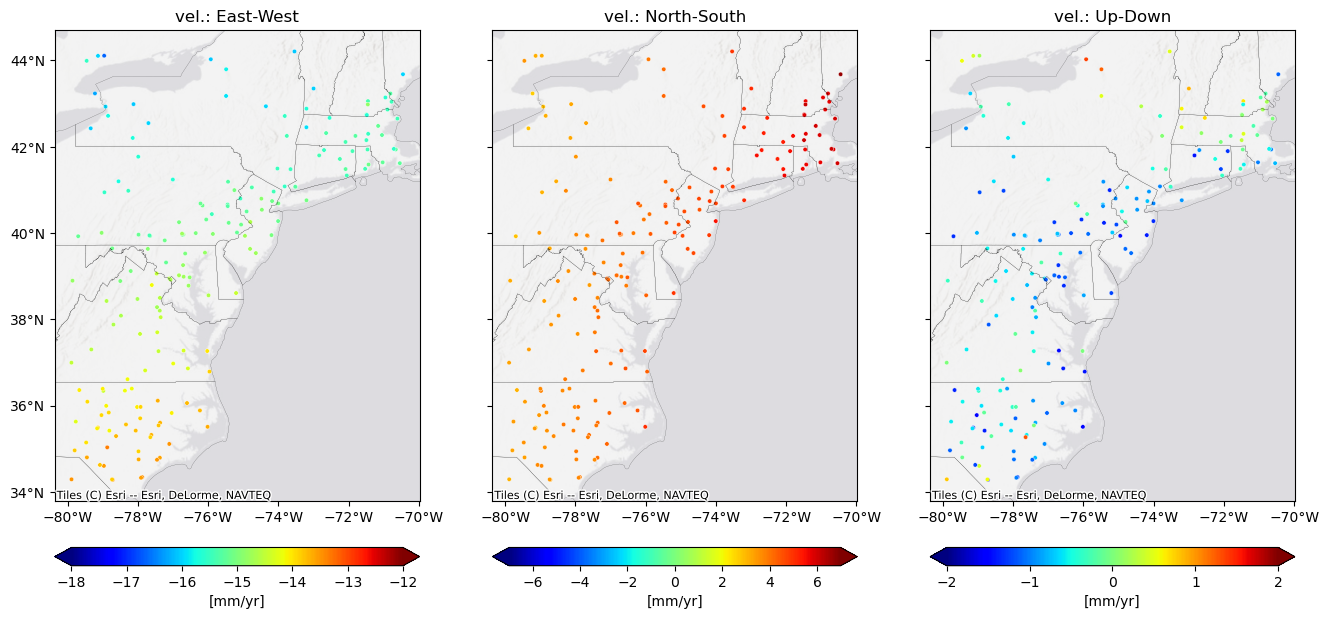

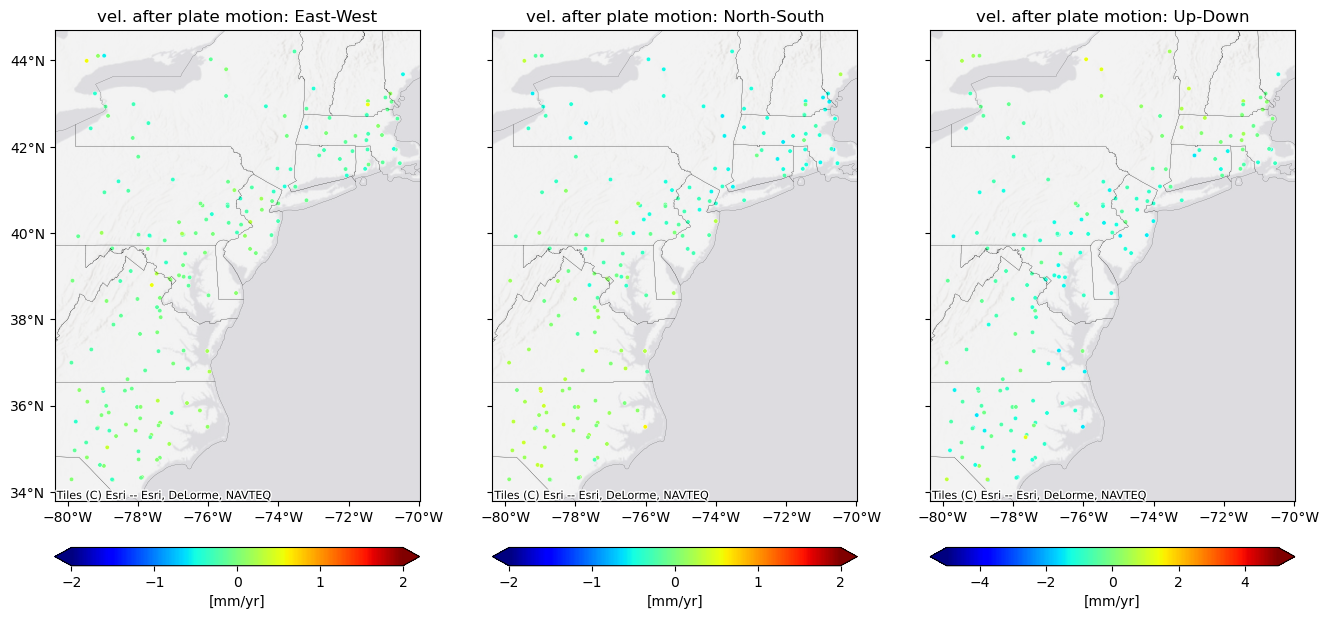

In [125]:
if option == 1:
    clim_list=[[-2, 2], [-2, 2], [-5, 5]]
else:
    clim_list=[[-40, 20], [-20, 30], [-2, 2]]

# Plot
# Before correction
fig, ax  = _plot_gnss(_filter_grid_points(mov_df,'sites'),
                prefix_title='vel.:',
                column_list=['e','n','v'],
                cmap_list=['jet', 'jet', 'jet'],
                clim_list=[[-18, -12], [-7, 7], [-2, 2]], **aux)
for a in ax: plates.exterior.plot(ax=a, lw=0.5, marker='--', color='maroon')

# After correction
fig, ax = _plot_gnss(mov_df,
               prefix_title='vel. after plate motion:',
               column_list=['res_e','res_n','res_v'],
               cmap_list=['jet', 'jet', 'jet'],
               clim_list=clim_list, **aux)
for a in ax: plates.exterior.plot(ax=a, lw=0.5, marker='--', color='maroon')

In [69]:
mov_df = mov_df.drop(mov_df[mov_df.res_e.abs()>0.6].index, axis=0)
mov_df = mov_df.drop(mov_df[mov_df.res_n.abs()>0.6].index, axis=0)
mov_df = mov_df.drop(mov_df[mov_df.res_v.abs()>1.5].index, axis=0)

In [70]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
mov_df.res_e.hist(ax=ax[0])
mov_df.res_n.hist(ax=ax[1])
mov_df.res_v.hist(ax=ax[2])
for a, txt in zip(ax, ['EW', 'NS', 'UD']): a.set_title(txt)

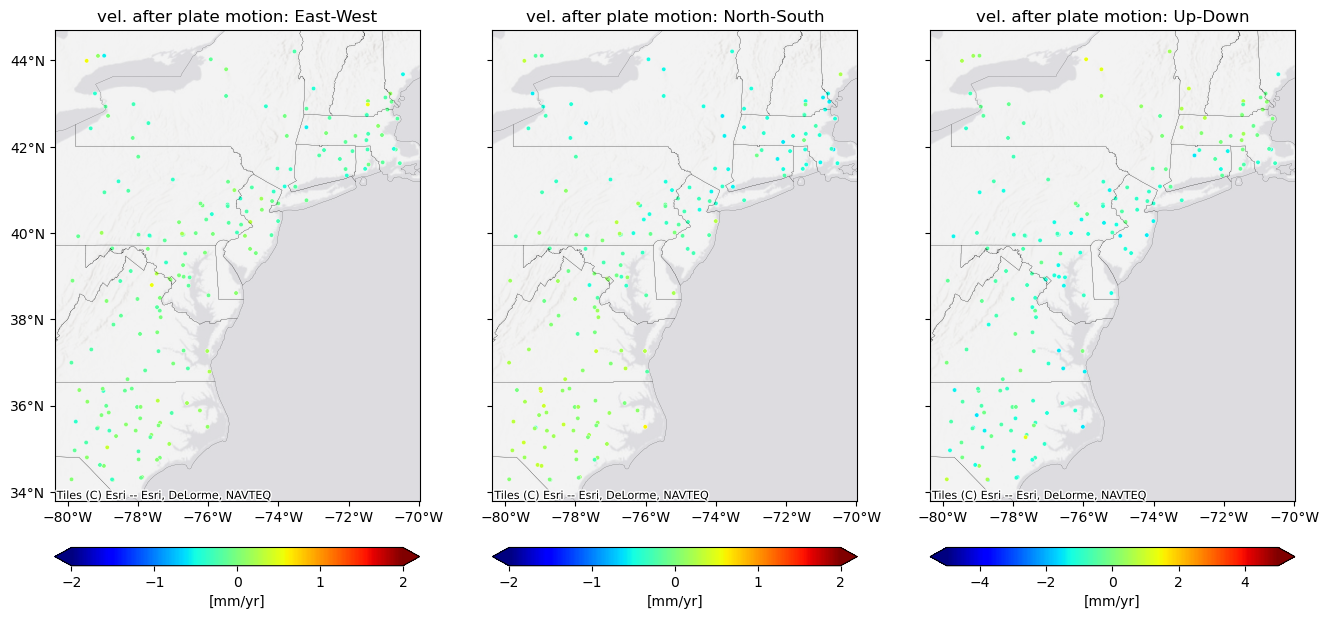

In [71]:
# After correction
fig, ax = _plot_gnss(mov_df,
               prefix_title='vel. after plate motion:',
               column_list=['res_e','res_n','res_v'],
               cmap_list=['jet', 'jet', 'jet'],
               clim_list=clim_list, **aux)
for a in ax: plates.exterior.plot(ax=a, lw=0.5, marker='--', color='maroon')

# Least Square Collocation - Hv-LSCex2

## Horizontal components

### Estimate Empirical Covariance

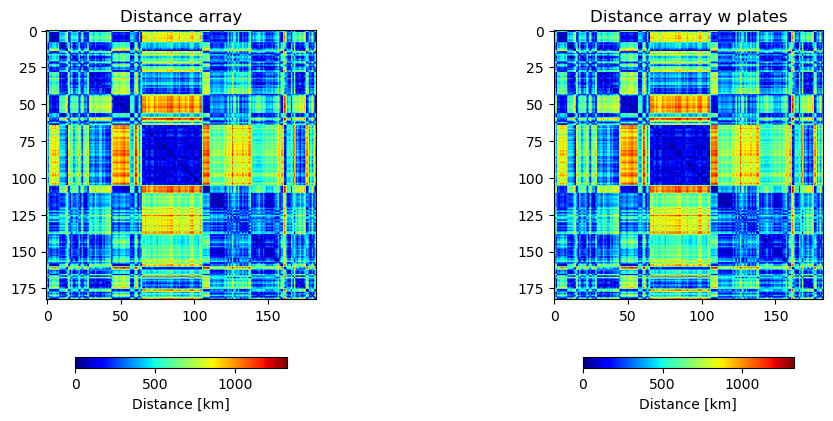

In [72]:
# Use position adjusted for plate boundary > moved 1.5e3 km
lat = _filter_grid_points(mov_df,'sites').mov_lat.values
lon = _filter_grid_points(mov_df,'sites').mov_lon.values

# Use GNSS position
lon_gnss = _filter_grid_points(mov_df,'sites').lon.values
lat_gnss = _filter_grid_points(mov_df,'sites').lat.values

# Vizualize distnace matrix with and without plate boundary constrain
distance_matrix_gnss = hvlsc.utils.get_distance_matrix(lon_gnss, lat_gnss,
                                                           lon_gnss, lat_gnss,
                                                           unit='km')

distance_matrix_plates = hvlsc.utils.get_distance_matrix(lon, lat,
                                                             lon, lat,
                                                             unit='km')

# Plot
fig ,ax = plt.subplots(1,2, figsize=(12, 5))
im1 = ax[0].imshow(distance_matrix_gnss, cmap='jet')
im2 = ax[1].imshow(distance_matrix_plates, cmap='jet')
im = [im1, im2]

# Title
txt = ['Distance array', 'Distance array w plates']
for i, a, t in zip(im, ax, txt): 
    a.set_title(t)
    fig.colorbar(i, ax=a, 
                 location='bottom', label='Distance [km]',
                 shrink=0.5)

50
Estimating empirical covariance for: ee component
Final values:
C0 = 0.99783 +/- 0.00000, d0 = 149 +/- 137
Misfit is: 0.55169
Misfit of the first three points is: 0.15652
Pearsons correlation: 0.782 

Estimating empirical covariance for: en component
Final values:
C0 = -0.33855 +/- 0.00000, d0 = 149 +/- 255
Misfit is: -1.02359
Misfit of the first three points is: -0.68273
Pearsons correlation: 0.708 

Estimating empirical covariance for: ne component
Final values:
C0 = -0.33855 +/- 0.00000, d0 = 149 +/- 346
Misfit is: -1.38806
Misfit of the first three points is: -0.64924
Pearsons correlation: 0.621 

Estimating empirical covariance for: nn component
Final values:
C0 = 1.00263 +/- 0.00000, d0 = 149 +/- 95
Misfit is: 0.38332
Misfit of the first three points is: 0.15748
Pearsons correlation: 0.883 

75
Estimating empirical covariance for: ee component


/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:203: RuntimeWarning: invalid value encountered in scalar divide
  bin_means.append(np.sum(bin_data) / (count - 1) / norm)
/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:204: RuntimeWarning: invalid value encountered in divide
  bin_stds.append(np.std(bin_data / norm))


Final values:
C0 = 0.99783 +/- 0.00000, d0 = 196 +/- 184
Misfit is: 0.51945
Misfit of the first three points is: 0.14136
Pearsons correlation: 0.849 

Estimating empirical covariance for: en component
Final values:
C0 = -0.33855 +/- 0.00000, d0 = 224 +/- 340
Misfit is: -0.88961
Misfit of the first three points is: -0.62011
Pearsons correlation: 0.811 

Estimating empirical covariance for: ne component
Final values:
C0 = -0.33855 +/- 0.00000, d0 = 224 +/- 492
Misfit is: -1.28900
Misfit of the first three points is: -0.53313
Pearsons correlation: 0.708 

Estimating empirical covariance for: nn component
Final values:
C0 = 1.00263 +/- 0.00000, d0 = 176 +/- 116
Misfit is: 0.34868
Misfit of the first three points is: 0.12037
Pearsons correlation: 0.923 

100
Estimating empirical covariance for: ee component
Final values:
C0 = 0.99783 +/- 0.00000, d0 = 194 +/- 239
Misfit is: 0.59776
Misfit of the first three points is: 0.15172
Pearsons correlation: 0.858 

Estimating empirical covariance for

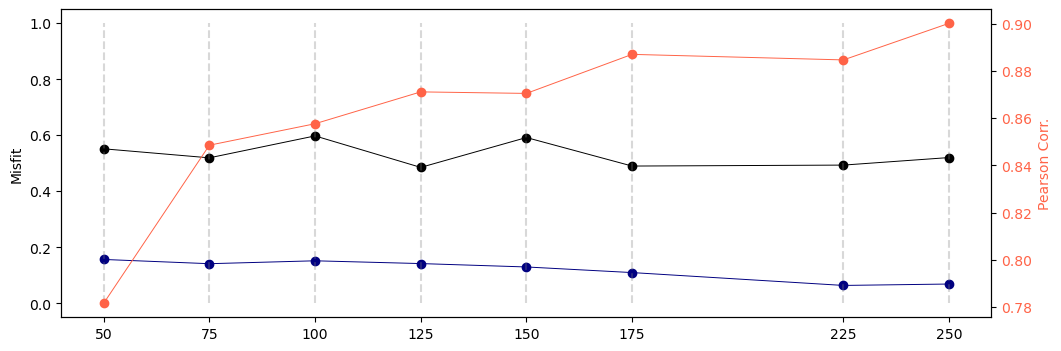

In [162]:
# Find bin size
search_bin_size = [50,75,100,125,150, 175, 225,250]
# this needs to be run 4 times for ew-ew, ew-ns, ns-ew, ns-ns

iteration_order=['ee', 'en', 'ne', 'nn']
#ew = _filter_grid_points(mov_df, 'sites').res_e.values
#ns = _filter_grid_points(mov_df, 'sites').res_n.values
ew = _filter_grid_points(mov_df, 'sites').e.values
ns = _filter_grid_points(mov_df, 'sites').n.values
se = _filter_grid_points(mov_df, 'sites').se.values
sn = _filter_grid_points(mov_df, 'sites').sn.values

# Minimum noise floos
se[se<0.3]=0.3
sn[sn<0.3]=0.3


mean_ew = np.mean(ew)
mean_ns = np.mean(ns)

# Substract the mean
ew -= mean_ew 
ns -= mean_ns 

iteration_data= dict(data1=[ew, ew, ns, ns],
                     data2=[ew, ns, ew, ns],
                     noise1=[se, se, sn, sn],
                     noise2=[se, sn, se, sn])


# Use Correlation Analysis to find 
ecov_lists = []
for bin_size in search_bin_size:
       print(bin_size)
       fparameters = []
       ferrors = []
       stats = []
       for ix, order in enumerate(iteration_order):
              print('Estimating empirical covariance for: '
                     f'{order} component')

              data1 = iteration_data['data1'][ix]
              data2 = iteration_data['data2'][ix]
              noise1 = iteration_data['noise1'][ix]
              noise2 = iteration_data['noise2'][ix]

              # Estimate empirical covariance
              popt, perr, stat = hvlsc.empirical_covariance.get_empirical_covariance(
                                                               lon, lat, 
                                                               data1, data2, 
                                                               noise1, noise2, 
                                                               correlation_analysis=True, 
                                                               bin_spacing=np.rint(bin_size),
                                                               constrain_mask=None,
                                                               max_range=1480,
                                                               plot_covariance=False)
              fparameters.append(popt)
              ferrors.append(perr)
              stats.append(stat)
       #fparameters = np.vstack(fparameters)
       #ferrors = np.vstack(ferrors)
       ecov_lists.append({f'{bin_size}':np.hstack([np.vstack(fparameters), np.vstack(ferrors)]), 'stats':stats})


# PLOT
ebins = [int(list(ecov_bin.keys())[0]) for ecov_bin in ecov_lists]
emisfit = [ecov_bin['stats'][0]['misfit'] for ecov_bin in ecov_lists]
emisfit1 = [ecov_bin['stats'][0]['misfit_1st'] for ecov_bin in ecov_lists]
epearson = [ecov_bin['stats'][0]['pearson'] for ecov_bin in ecov_lists]

fig, ax = plt.subplots(1, figsize=(12,4))
ax.set_ylabel('Misfit', color='black')
ax.set_xticks(ebins)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Pearson Corr.', color='tomato') 
ax2.tick_params(axis='y', labelcolor='tomato')

# Plot
ax.plot(ebins, emisfit, '-ko', lw=0.7)
ax.plot(ebins, emisfit1, '-o', lw=0.7, color='navy')
ax2.plot(ebins, epearson, '-o', lw=0.7, color='tomato')
ax.vlines(ebins, 0, 1, linestyles='dashed', color='gray', alpha=0.3)

Due to the remaining trends in the data associated with interplate deformation, empirical covariance gives biased results. Thus, use correlation analysis to obtain correlation length d0 and change covariance c0 parameter with the mean velocity variance estimated prior with Hector.

Estimating empirical covariance for: ee component
Final values:
C0 = 0.44742 +/- 0.00000, d0 = 204 +/- 304
Misfit is: 0.83993
Misfit of the first three points is: 0.22339
Pearsons correlation: 0.786 

Estimating empirical covariance for: en component
Final values:
C0 = -0.53068 +/- 0.00000, d0 = 157 +/- 185
Misfit is: -0.59228
Misfit of the first three points is: -0.13388
Pearsons correlation: 0.754 

Estimating empirical covariance for: ne component
Final values:
C0 = -0.53068 +/- 0.00000, d0 = 157 +/- 185
Misfit is: -0.59228
Misfit of the first three points is: -0.13388
Pearsons correlation: 0.754 

Estimating empirical covariance for: nn component
Final values:
C0 = 0.61395 +/- 0.00000, d0 = 186 +/- 175
Misfit is: 0.51081
Misfit of the first three points is: 0.20336
Pearsons correlation: 0.886 



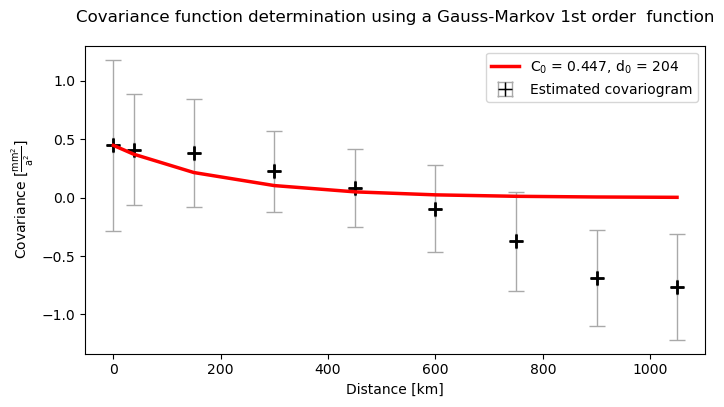

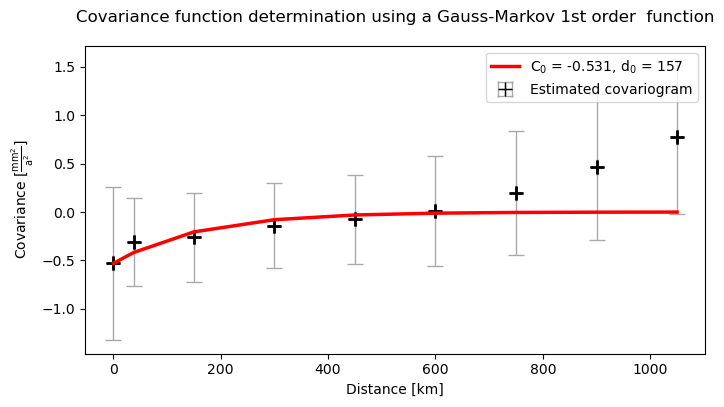

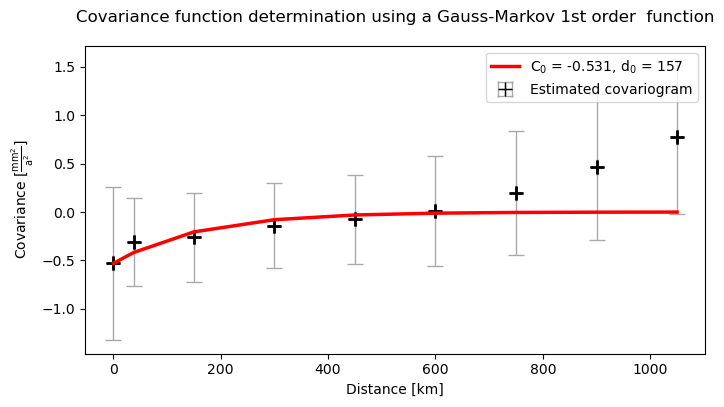

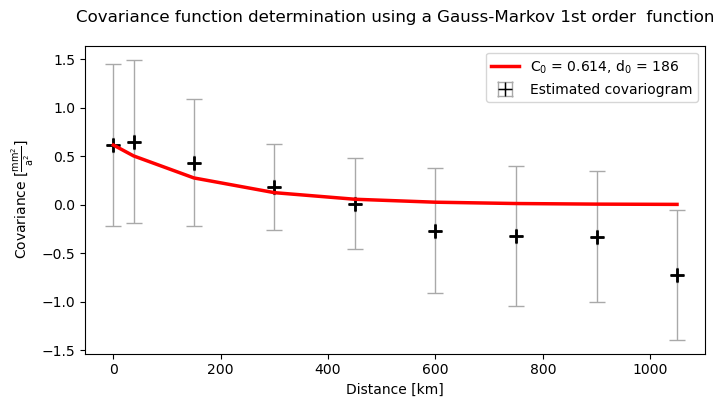

In [163]:
bin_size = 75 

# Empirical covariance analysis
fparameters = []
ferrors = []
stats = []
for ix, order in enumerate(iteration_order):
        print('Estimating empirical covariance for: '
                f'{order} component')

        data1 = iteration_data['data1'][ix]
        data2 = iteration_data['data2'][ix]
        noise1 = iteration_data['noise1'][ix]
        noise2 = iteration_data['noise2'][ix]

        # Estimate empirical covariance
        popt, perr, stat = hvlsc.empirical_covariance.get_empirical_covariance(
                                                        lon, lat, 
                                                        data1, data2, 
                                                        noise1, noise2, 
                                                        correlation_analysis=False, 
                                                        bin_spacing=np.rint(bin_size),
                                                        constrain_mask=None,
                                                        max_range=None,
                                                        plot_covariance=True)
        fparameters.append(popt)
        ferrors.append(perr)
        stats.append(stat)
fparameters = np.vstack(fparameters)
ferrors = np.vstack(ferrors)

In [94]:
np.mean(gnss_df2.sn)

0.22476955191127457

In [78]:
# Replace c0 with mean velocity variance
fparameters[0,0] *= np.mean(gnss_df2.se)**2
fparameters[1,0] *= (np.sqrt(np.mean(gnss_df2.se)**2 + np.mean(gnss_df2.sn)**2)**2)
fparameters[2,0] *= (np.sqrt(np.mean(gnss_df2.se)**2 + np.mean(gnss_df2.sn)**2)**2)
fparameters[3,0] *= np.mean(gnss_df2.sn)**2
fparameters

array([[4.71202679e-02, 2.78368198e+01],
       [2.59910757e-02, 2.19380715e+02],
       [2.59910757e-02, 2.17982916e+02],
       [5.09064382e-02, 1.52740256e+02]])

#### Combined estimation of empirical covariance for EW and NS using Julius Legrande method

In [79]:
starting_model = [1., 100000.]
function_parameter = [1, 300]
# NOTE if function_parameter is not defined, estimate it

# Skip this step as it might take some time and have memory associated problems
# depends on the number of inputs 
skip_flag = False 

Covariance JL
Outlier identified and removed
Bin: 0, Count: 180, N_Bin: 7
Get BETA
Get COV BETA
(360, 360) (360, 360, 2)
  Cov mem: 1.98 MB
Finished calculating covBeta: 0.00 min
 Cov Beta shape: (360, 360)
Bin: 1, Count: 1525, N_Bin: 7
Get BETA
Get COV BETA
(6100, 6100) (6100, 6100, 2)
  Cov mem: 567.78 MB
(6100, 6100) (6100, 6100, 2)
  Cov mem: 567.78 MB
(6100, 6100) (6100, 6100, 2)
  Cov mem: 567.78 MB
(6100, 6100) (6100, 6100, 2)
  Cov mem: 567.78 MB
Finished calculating covBeta: 0.53 min
 Cov Beta shape: (6100, 6100)
Bin: 2, Count: 5234, N_Bin: 7
Get BETA
Get COV BETA
(20936, 20936) (20936, 20936, 2)
  Cov mem: 6688.17 MB
(20936, 20936) (20936, 20936, 2)
  Cov mem: 6688.17 MB
(20936, 20936) (20936, 20936, 2)
  Cov mem: 6688.17 MB
(20936, 20936) (20936, 20936, 2)
  Cov mem: 6688.17 MB
Finished calculating covBeta: 6.36 min
 Cov Beta shape: (20936, 20936)
Bin: 3, Count: 4799, N_Bin: 7
Get BETA
Get COV BETA
(19196, 19196) (19196, 19196, 2)
  Cov mem: 5622.66 MB
(19196, 19196) (19196,

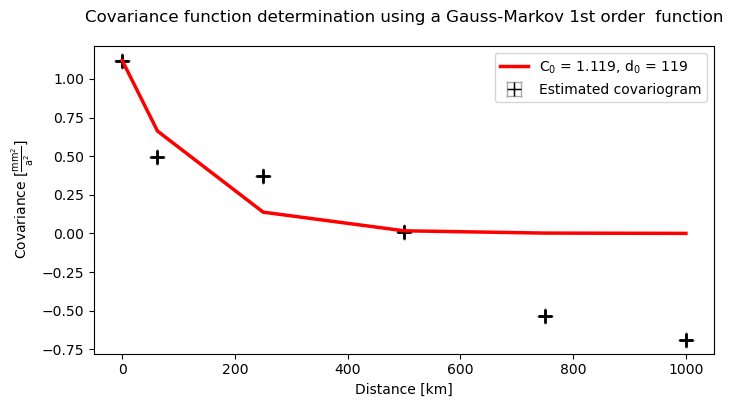

In [80]:
%%time

if skip_flag is False:
    # Getting kernel crashes for cov beta aorund 40k x 40k points
    # NOTE: adjust to write matrices F,K,C locally and use it to get cov_beta to avoid memory overflow
    print('Covariance JL')
    decimate=1
    while ((function_parameter[1] - starting_model[1]) > 5) or ((function_parameter[1] - starting_model[1]) < -5):
        starting_model = function_parameter
        popt, perr  = hvlsc.empirical_covariance_jl.get_empirical_covariance_jl(
                                                    lon[::decimate], lat[::decimate],
                                                    ew[::decimate], ns[::decimate],
                                                    se[::decimate], sn[::decimate],
                                                    function_parameter,
                                                    bin_spacing=np.rint(bin_size),
                                                    correlation_analysis=True,
                                                    max_range=1500)

    fparameters = np.repeat(np.atleast_2d(popt), 4, axis=0)
    ferrors = np.repeat(np.atleast_2d(perr), 4, axis=0)
    fparameters, ferrors 

In [81]:
fparameters

array([[  1.11906479, 119.29988068],
       [  1.11906479, 119.29988068],
       [  1.11906479, 119.29988068],
       [  1.11906479, 119.29988068]])

In [82]:
fparameters[:,0] *= (np.sqrt(gnss_df2.se.mean()**2 + gnss_df2.sn.mean()**2))**2

### Covariance matrix at known points

Getting covariance component: "ee"
Getting covariance component: "en"
Getting covariance component: "ne"
Getting covariance component: "nn"
Noise-covariance matrix Cnn created
Lowest eigenvalue: 1.32937e-04; Symmetry check: 6.85297e-10
Css matrix is positive definite


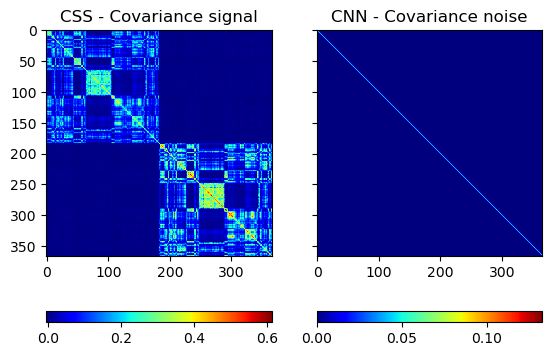

In [164]:
# Get covariance at known points
CSS = hvlsc.covariance.create_Css(lon, lat,
                                  lon, lat, 
                                  hvlsc.models.func_gm1,
                                  fparameters, cross_corelation=True)
CNN = hvlsc.covariance.create_Cnn(np.c_[se, sn])

# Plot
fig, ax = plt.subplots(1,2, sharey=True)
im1 = ax[0].imshow(CSS, cmap='jet')
im2 = ax[1].imshow(CNN, cmap='jet')
[fig.colorbar(im, ax=a, location='bottom') for im, a in zip([im1, im2], ax)]
[a.set_title(txt) for a, txt in zip(ax, ['CSS - Covariance signal', 'CNN - Covariance noise'])]

# Check if covariance is positive definite
eigenvalsh = np.linalg.eigvalsh(CSS)
print('Lowest eigenvalue: %8.5e; Symmetry check: %8.5e'%(np.amin(eigenvalsh), np.amax(np.abs(CSS - CSS.T))))
epsilon = 1e-10
if (np.all(eigenvalsh) >= -epsilon) and (np.amin(eigenvalsh) <= 0) and (np.abs(CSS - CSS.T) <= 1e-2).all():
    print('Css matrix is positive semi-definite')
elif np.all(eigenvalsh) > 0 and (np.abs(CSS - CSS.T) <= 1e-2).all():
    print('Css matrix is positive definite')
else:
    raise ValueError('Css matrix is not positive definite and collocation cannot be done')

#### Moving variance estimation

In [165]:
# Flag to use moving variance
use_moving_var = False 

# Parameters
delta_mov = 800 #km radius for calc variance
mov_min_num = 3 # min number of stations within delta mov
mov_c0 = 1 # correlation factor
C0_movvar = fparameters.copy() 
#C0_movvar[:, 0] = fparameters[:,0]
#C0_movvar[0,0] *= np.mean(gnss_df2.se)**2
#C0_movvar[1,0] *= (np.sqrt(np.mean(gnss_df2.se)**2 + np.mean(gnss_df2.sn)**2)**2)
#C0_movvar[2,0] *= (np.sqrt(np.mean(gnss_df2.se)**2 + np.mean(gnss_df2.sn)**2)**2)
#C0_movvar[3,0] *= np.mean(gnss_df2.sn)**2

if use_moving_var:
    print('Estimate moving variance!')
    # Estimate
    Css_mov = hvlsc.covariance.get_moving_Css(
                            lon, lat,
                            lon, lat, 
                            np.c_[ew, ns],
                            C0_movvar, delta_mov,
                            min_number=mov_min_num,
                            fill_value=None)


    print('Moving variance for Css created.')
    CSS_mov = CSS * Css_mov

    # Plot
    fig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)
    im1 = ax[0].imshow(Css_mov, cmap='jet')
    im2 = ax[1].imshow(CSS_mov, cmap='jet')
    [fig.colorbar(im, ax=a, location='bottom') for im,a in zip([im1,im2], ax)]
    [a.set_title(txt) for a, txt in zip(ax, ['Moving variance Cmov ', 'CSS_mov - Covariance signal w mov. var.'])]


    # Check if covariance is positive definite
    eigenvalsh = np.linalg.eigvalsh(CSS_mov)
    print('Lowest eigenvalue: %8.5e; Symmetry check: %8.5e'%(np.amin(eigenvalsh), np.amax(np.abs(CSS_mov - CSS_mov.T))))
    epsilon = 1e-10
    if (np.all(eigenvalsh) >= -epsilon) and (np.amin(eigenvalsh) <= 0) and (np.abs(CSS_mov - CSS_mov.T) <= 1e-2).all():
        print('Css matrix is positive semi-definite')
    elif np.all(eigenvalsh) > 0 and (np.abs(CSS_mov - CSS_mov.T) <= 1e-2).all():
        print('Css matrix is positive definite')
    else:
        raise ValueError('Css matrix is not positive definite and collocation cannot be done')

### Collocation at known points

Collocation at the observation points is done.


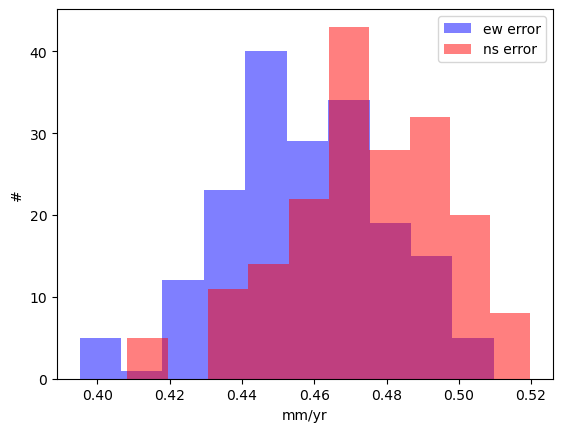

In [166]:
CSS_input = CSS_mov if use_moving_var else CSS

[signal_xy, signal_xy_error, 
 noise_xy, C_inv] = hvlsc.collocation.collocation_signal_known(
                                            np.c_[ew, ns], 
                                            CSS_input, CNN)

# Plot Histograms
fig, ax = plt.subplots(1)
ax.hist(np.sqrt(signal_xy_error[:,0]), alpha=0.5, color='blue', label='ew error')
ax.hist(np.sqrt(signal_xy_error[:,1]), alpha=0.5, color='red', label='ns error')
ax.set_xlabel('mm/yr')
ax.set_ylabel('#')
ax.legend()

In [86]:
horizontal_xy_error = signal_xy_error

### Collocation at interpolation grid

Loop 1
Getting covariance component: "ee"
Getting covariance component: "en"
Getting covariance component: "ne"
Getting covariance component: "nn"
Getting covariance component: "ee"
Getting covariance component: "en"
Getting covariance component: "ne"
Getting covariance component: "nn"
Collocation at the interpolation points is done.


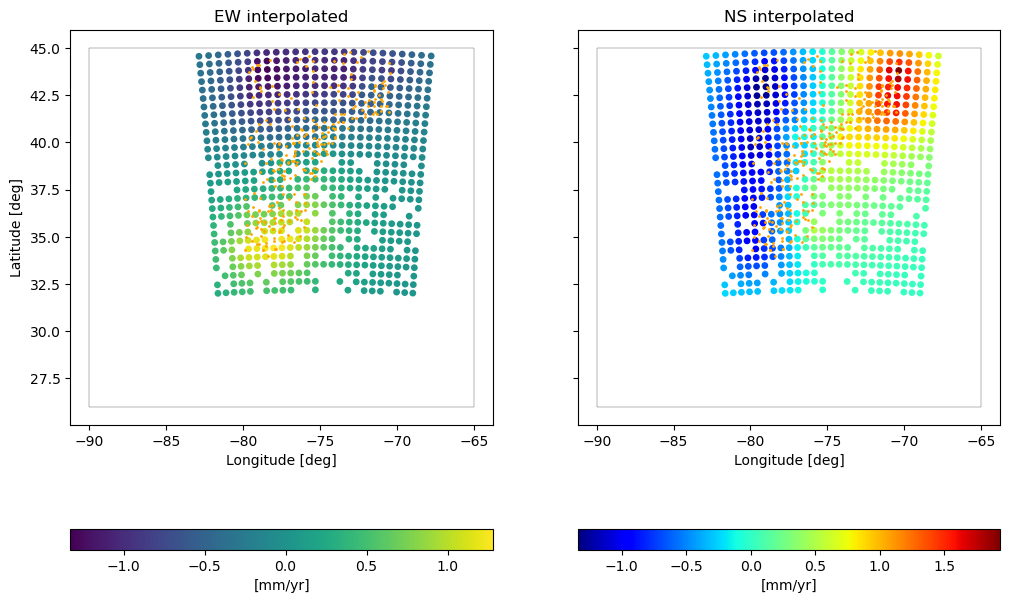

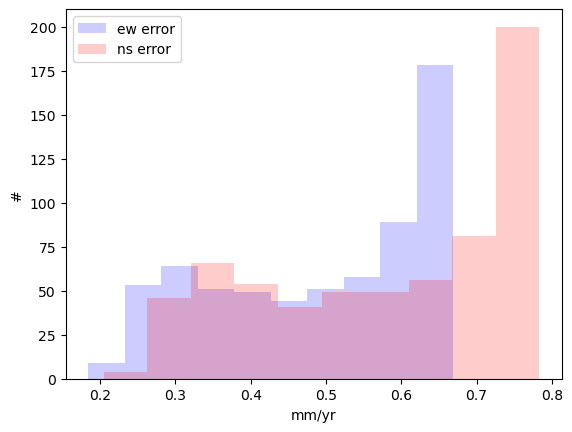

In [167]:
grid_lon = _filter_grid_points(mov_df,'grid').mov_lon.values
grid_lat = _filter_grid_points(mov_df,'grid').mov_lat.values
grid_out, grid_error = collocation2grid(lon, lat,
                                        grid_lon, grid_lat,
                                        np.c_[ew, ns],
                                        C_inv,
                                        fparameters,
                                        movvar_parameters=[C0_movvar[:,0], delta_mov, 
                                                           None, mov_min_num],
                                        moving_variance=use_moving_var)

# PLOT
grid_lon = _filter_grid_points(mov_df,'grid').lon.values
grid_lat = _filter_grid_points(mov_df,'grid').lat.values

fig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)
im1=ax[0].scatter(grid_lon, grid_lat, s=15, marker='o', c=grid_out[:,0], cmap='viridis')
im2=ax[1].scatter(grid_lon, grid_lat, s=15, marker='o', c=grid_out[:,1], cmap='jet')
[a.plot(gnss_df2.lon, gnss_df2.lat,'o', markersize=1, color='orange') for a in ax]
[fig.colorbar(im, ax=a, location='bottom', label='[mm/yr]') for im, a in zip([im1, im2], ax)]
[a.set_title(txt) for a, txt in zip(ax, ['EW interpolated', 'NS interpolated'])]
plates.exterior.plot(ax=ax[0], color='black', linewidth=0.2)
plates.exterior.plot(ax=ax[1], color='black', linewidth=0.2)
ax[0].set_ylabel('Latitude [deg]')

for a in ax: 
    #a.set_xlim([10, 80]), a.set_ylim([-25, 41])
    a.set_xlabel('Longitude [deg]')

fig, ax = plt.subplots(1)
ax.hist(grid_error[:,0], alpha=0.2, color='blue', label='ew error')
ax.hist(grid_error[:,1], alpha=0.2, color='red', label='ns error')
ax.set_xlabel('mm/yr')
ax.set_ylabel('#')
ax.legend()

In [168]:
# Create collocation grid
collocation_df = gpd.GeoDataFrame([],
                           geometry = gpd.points_from_xy(grid_lon,
                                                         grid_lat),
                           crs='EPSG:4326')

collocation_df['ew'] = grid_out[:, 0]
collocation_df['ns'] = grid_out[:, 1]
collocation_df['sew'] = grid_error[:, 0] 
collocation_df['sns'] = grid_error[:, 1] 

collocation_df['plate'] = None
for _, plate in plates.iterrows():
    ix = collocation_df[collocation_df.within(plate.geometry)].index
    collocation_df.loc[ix, 'plate'] = plate.Code

print(f'GNSS sites cover: {list(collocation_df.plate.unique())} plates')

collocation_df['lon'] = collocation_df.geometry.apply(lambda x: x.xy[0][0])
collocation_df['lat'] = collocation_df.geometry.apply(lambda x: x.xy[1][0])

GNSS sites cover: ['NA'] plates


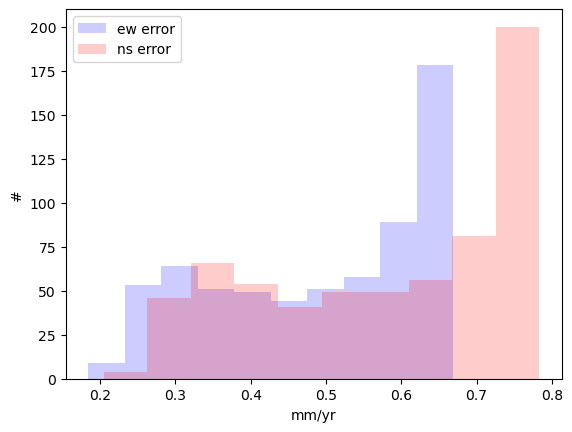

In [169]:
#flag = collocation_df.within(ocean.unary_union)

# Without ocean
fig, ax = plt.subplots(1)
ax.hist(grid_error[:,0], alpha=0.2, color='blue', label='ew error')
ax.hist(grid_error[:,1], alpha=0.2, color='red', label='ns error')
ax.set_xlabel('mm/yr')
ax.set_ylabel('#')
ax.legend()

In [170]:
# Restore trend assoicated with plate motion
if option==1:
    # Option 1: Relative to North America
    plate_omegas = plate_motion[plate_motion.code == code2itrf['NA']]
    print('NA', plate_omegas)

    plate_v = predict_plate_motion(collocation_df.lon.values, 
                                collocation_df.lat.values,
                                plate_omegas.omega_x, 
                                plate_omegas.omega_y, 
                                plate_omegas.omega_z)
                    
    collocation_df['plate_ew'] = np.float64(plate_v)[:,0]
    collocation_df['plate_ns'] = np.float64(plate_v)[:,1]
    collocation_df['plate_up'] = np.float64(plate_v)[:,2]

elif option==2:
    # Option 2. Remove both NORTH AMERICA & PACIFIC plate motion
    for p in ['NA', 'PA']:
        plate_grid = collocation_df[collocation_df.plate == p]
        plate_omegas = plate_motion[plate_motion.code == code2itrf[p]]
        print(p, plate_omegas)

        plate_v = predict_plate_motion(plate_grid.lon.values, 
                                    plate_grid.lat.values,
                                    plate_omegas.omega_x, 
                                    plate_omegas.omega_y, 
                                    plate_omegas.omega_z)
                        
        collocation_df.loc[collocation_df.plate == p,
                ['plate_ew', 'plate_ns', 'plate_up']] = np.float64(plate_v)
else:
    collocation_df['plate_ew'] = np.zeros_like(collocation_df.ew.values)
    collocation_df['plate_ns'] = np.zeros_like(collocation_df.ew.values) 
    collocation_df['plate_up'] = np.zeros_like(collocation_df.ew.values)

NA    code  omega_x  omega_y  omega_z
6  NOAM   0.0066  -0.1928  -0.0176


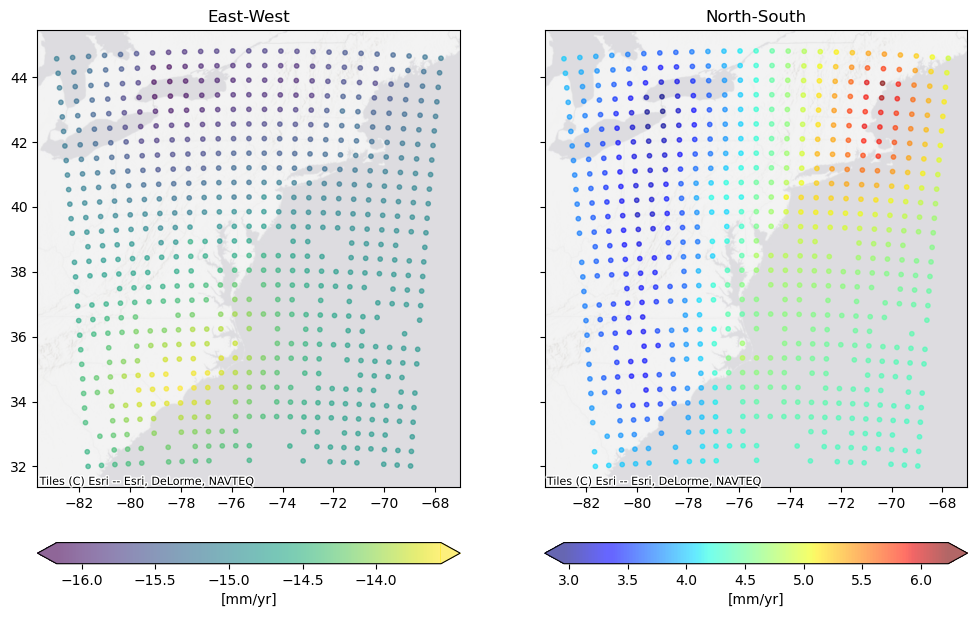

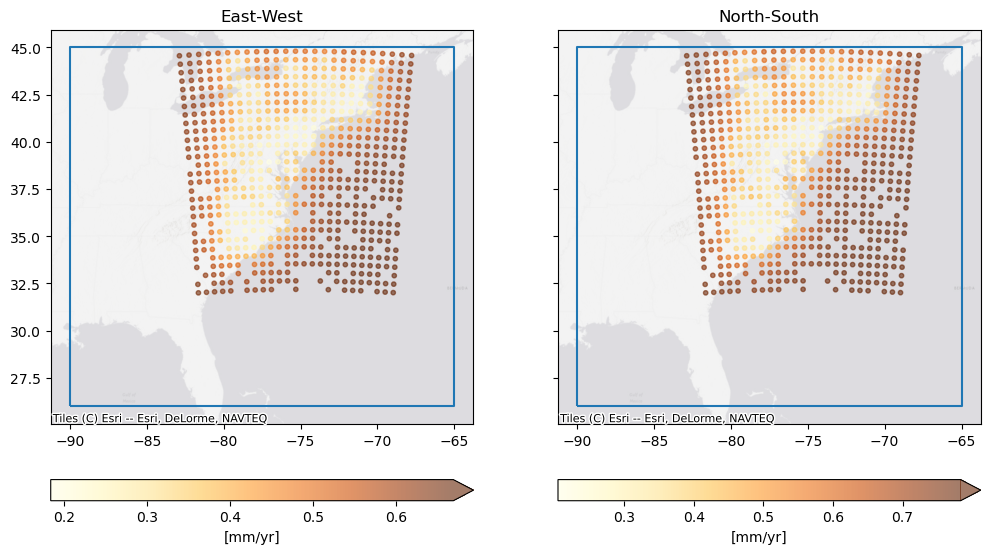

In [171]:
# Restore mean and trends
#collocation_df['ew'] = collocation_df['plate_ew'] + grid_out[:, 0] + mean_ew 
#collocation_df['ns'] = collocation_df['plate_ns'] + grid_out[:, 1] + mean_ns
collocation_df['ew'] = grid_out[:, 0] + mean_ew 
collocation_df['ns'] = grid_out[:, 1] + mean_ns

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,9))
im1 = collocation_df.plot(column='ew', ax=ax[0], cmap='viridis', markersize=10, alpha=0.6)
im2 = collocation_df.plot(column='ns', ax=ax[1], cmap='jet', markersize=10, alpha=0.6)

#plates.exterior.plot(ax=ax[0])
#plates.exterior.plot(ax=ax[1])
for a, txt in zip(ax, ['East-West', 'North-South']): a.set_title(txt)
for a, im in zip(ax, [im1, im2]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.08, 
                 extend='both', label='[mm/yr]')
    _add_basemap(a, 0, alpha=1, zoom=6, source='hillshade')
    _add_basemap(a, 0, alpha=0.7, zoom=6, source='gray_canvas') 
    

fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,9))
im1 = collocation_df.plot(column='sew', ax=ax[0], cmap='YlOrBr', markersize=10, alpha=0.6)
im2 = collocation_df.plot(column='sns', ax=ax[1], cmap='YlOrBr', markersize=10, alpha=0.6)

plates.exterior.plot(ax=ax[0])
plates.exterior.plot(ax=ax[1])
for a, txt in zip(ax, ['East-West', 'North-South']): a.set_title(txt)
for a, im in zip(ax, [im1, im2]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.08,
                 extend='max', label='[mm/yr]') 
    _add_basemap(a, 0, alpha=1, zoom=6, source='hillshade')
    _add_basemap(a, 0, alpha=0.7, zoom=6, source='gray_canvas') 

## Vertical

### Estimate Empirical Covariance

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 32 +/- 12
Misfit is: 0.14018
Misfit of the first three points is: 0.10850
Pearsons correlation: 0.928 

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 33 +/- 12
Misfit is: 0.13261
Misfit of the first three points is: 0.09369
Pearsons correlation: 0.950 

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 39 +/- 14
Misfit is: 0.11854
Misfit of the first three points is: 0.07271
Pearsons correlation: 0.960 

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 47 +/- 16
Misfit is: 0.11409
Misfit of the first three points is: 0.03389
Pearsons correlation: 0.975 

Estimating empirical covariance for: vv component
Outlier identified and removed

/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:203: RuntimeWarning: invalid value encountered in scalar divide
  bin_means.append(np.sum(bin_data) / (count - 1) / norm)
/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:204: RuntimeWarning: invalid value encountered in divide
  bin_stds.append(np.std(bin_data / norm))


Final values:
C0 = 1.00559 +/- 0.00000, d0 = 52 +/- 15
Misfit is: 0.09097
Misfit of the first three points is: 0.00788
Pearsons correlation: 0.989 

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 58 +/- 19
Misfit is: 0.10242
Misfit of the first three points is: 0.01051
Pearsons correlation: 0.987 

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 67 +/- 16
Misfit is: 0.06552
Misfit of the first three points is: 0.03432
Pearsons correlation: 0.997 



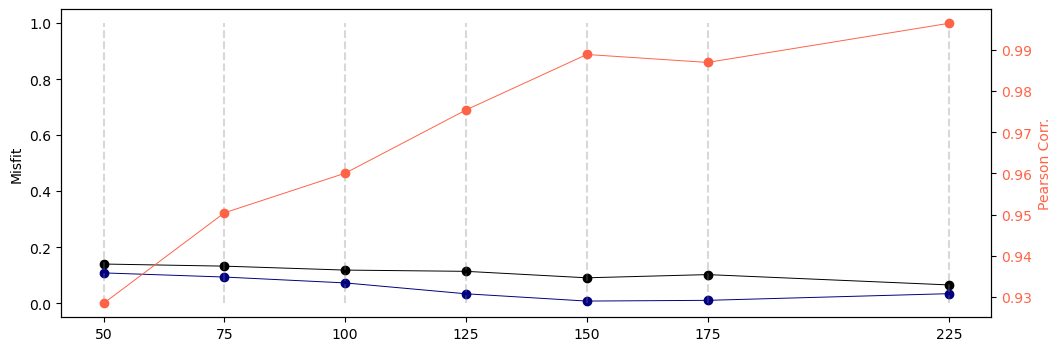

In [172]:
# Use position adjusted for plate boundary > moved 1e3 km
lat = _filter_grid_points(mov_df,'sites').mov_lat.values
lon = _filter_grid_points(mov_df,'sites').mov_lon.values

# Use GNSS position
lon_gnss = _filter_grid_points(mov_df,'sites').lon.values
lat_gnss = _filter_grid_points(mov_df,'sites').lat.values

#v = _filter_grid_points(mov_df,'sites').res_v
v = _filter_grid_points(mov_df,'sites').v
sv = _filter_grid_points(mov_df,'sites').sv 
iteration_order=['vv']

# Minimum noise floor
#sv[sv<0.3]=0.3


mean_v = np.mean(v)

# Substract the mean
v -= mean_v


# Find bin size
search_bin_size = [50, 75,100,125,150,175,225]

iteration_data= dict(data1=[v],
                     data2=[v],
                     noise1=[sv],
                     noise2=[sv])

ecov_lists = []
for bin_size in search_bin_size:
       fparameters = []
       ferrors = []
       stats = []
       for ix, order in enumerate(iteration_order):
              print('Estimating empirical covariance for: '
                     f'{order} component')

              data1 = iteration_data['data1'][ix]
              data2 = iteration_data['data2'][ix]
              noise1 = iteration_data['noise1'][ix]
              noise2 = iteration_data['noise2'][ix]

              # Estimate empirical covariance
              popt, perr, stat = hvlsc.empirical_covariance.get_empirical_covariance(
                                                               lon_gnss, lat_gnss, 
                                                               data1, data2, 
                                                               noise1, noise2, 
                                                               correlation_analysis=True, 
                                                               bin_spacing=np.rint(bin_size),
                                                               constrain_mask=None,
                                                               plot_covariance=False,
                                                                max_range=1500)
              fparameters.append(popt)
              ferrors.append(perr)
              stats.append(stat)

       ecov_lists.append({f'{bin_size}':np.hstack([np.vstack(fparameters), np.vstack(ferrors)]), 'stats':stats})

# PLOT
ebins = [int(list(ecov_bin.keys())[0]) for ecov_bin in ecov_lists]
emisfit = [ecov_bin['stats'][0]['misfit'] for ecov_bin in ecov_lists]
emisfit1 = [ecov_bin['stats'][0]['misfit_1st'] for ecov_bin in ecov_lists]
epearson = [ecov_bin['stats'][0]['pearson'] for ecov_bin in ecov_lists]

fig, ax = plt.subplots(1, figsize=(12,4))
ax.set_ylabel('Misfit', color='black')
ax.set_xticks(ebins)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Pearson Corr.', color='tomato') 
ax2.tick_params(axis='y', labelcolor='tomato')

# Plot
ax.plot(ebins, emisfit, '-ko', lw=0.7)
ax.plot(ebins, emisfit1, '-o', lw=0.7, color='navy')
ax2.plot(ebins, epearson, '-o', lw=0.7, color='tomato')
ax.vlines(ebins, 0, 1, linestyles='dashed', color='gray', alpha=0.3)

Estimating empirical covariance for: vv component
Outlier identified and removed
Final values:
C0 = 1.00559 +/- 0.00000, d0 = 60 +/- 15
Misfit is: 0.13203
Misfit of the first three points is: 0.07978
Pearsons correlation: 0.923 



/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:203: RuntimeWarning: invalid value encountered in scalar divide
  bin_means.append(np.sum(bin_data) / (count - 1) / norm)
/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/empirical_covariance.py:204: RuntimeWarning: invalid value encountered in divide
  bin_stds.append(np.std(bin_data / norm))


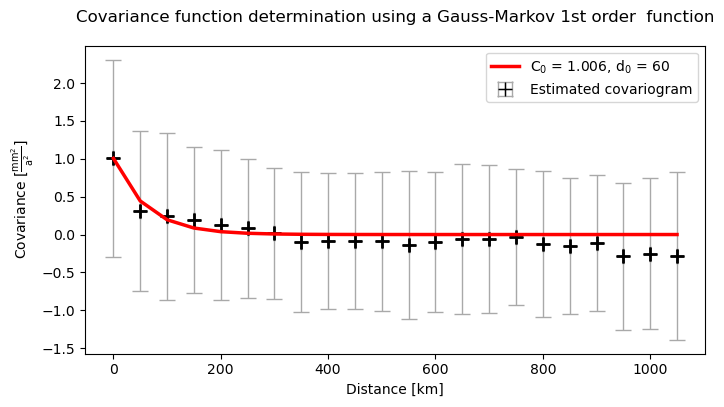

In [176]:
bin_size =25

fparameters = []
ferrors = []

for ix, order in enumerate(iteration_order):
       print('Estimating empirical covariance for: '
              f'{order} component')

       data1 = iteration_data['data1'][ix]
       data2 = iteration_data['data2'][ix]
       noise1 = iteration_data['noise1'][ix]
       noise2 = iteration_data['noise2'][ix]

       # Estimate empirical covariance
       popt, perr, stat = hvlsc.empirical_covariance.get_empirical_covariance(
                                                        lon_gnss, lat_gnss, 
                                                        data1, data2, 
                                                        noise1, noise2, 
                                                        correlation_analysis=True, 
                                                        bin_spacing=np.rint(bin_size),
                                                        constrain_mask=None,
                                                        max_range=1500)
       fparameters.append(popt)
       ferrors.append(perr)

fparameters = np.vstack(fparameters)
ferrors = np.vstack(ferrors)

In [177]:
fparameters[0,0] = np.sqrt(gnss_df2.sv.mean()**2)

In [178]:
fparameters

array([[ 0.71155095, 60.98601498]])

### Covariance matrix at known points

/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src/venti/gnss/interpolation/hvlsc_py3/src/covariance.py:81: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  noise = noise.ravel(order='F')


Noise-covariance matrix Cnn created
Lowest eigenvalue: 7.07975e-04; Symmetry check: 0.00000e+00
Css matrix is positive definite


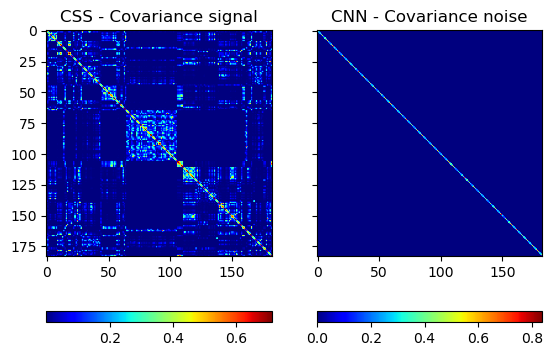

In [179]:
# Get covariance at known points
CSS = hvlsc.covariance.create_Css(lon_gnss, lat_gnss,
                                      lon_gnss, lat_gnss, 
                                      hvlsc.models.func_gm1,
                                      fparameters, iteration_order=['vv'],
                                      cross_corelation=False)
CNN = hvlsc.covariance.create_Cnn(sv)

# Plot
fig, ax = plt.subplots(1,2, sharey=True)
im1 = ax[0].imshow(CSS, cmap='jet')
im2 = ax[1].imshow(CNN, cmap='jet')
[fig.colorbar(im, ax=a, location='bottom') for im, a in zip([im1, im2], ax)]
[a.set_title(txt) for a, txt in zip(ax, ['CSS - Covariance signal', 'CNN - Covariance noise'])]

# Check if covariance is positive definite
eigenvalsh = np.linalg.eigvalsh(CSS)
print('Lowest eigenvalue: %8.5e; Symmetry check: %8.5e'%(np.amin(eigenvalsh), np.amax(np.abs(CSS - CSS.T))))
epsilon = 1e-10
if (np.all(eigenvalsh) >= -epsilon) and (np.amin(eigenvalsh) <= 0) and (np.abs(CSS - CSS.T) <= 1e-2).all():
    print('Css matrix is positive semi-definite')
elif np.all(eigenvalsh) > 0 and (np.abs(CSS - CSS.T) <= 1e-2).all():
    print('Css matrix is positive definite')
else:
    raise ValueError('Css matrix is not positive definite and collocation cannot be done')

#### Moving variance estimation

In [44]:
'''
SKIP as need to do the moving variance for vertical 

delta_mov = 50 #km radius for calc variance
mov_min_num = 5 # min number of stations within delta mov
mov_c0 = 1 # correlation factor
C0_movvar = fparameters.copy() 
C0_movvar[:, 0] = np.ones(len(fparameters)) * mov_c0 

# Estimate
Css_mov = py3_hvlsc.covariance.get_moving_Css(
                         lon_gnss, lat_gnss,
                         lon_gnss, lat_gnss, 
                         v,
                         C0_movvar, delta_mov,
                         iteration_order=['v'],
                         min_number=mov_min_num)

print('Moving variance for Css created.')
CSS_mov = CSS * Css_mov

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)
im1 = ax[0].imshow(Css_mov, cmap='jet')
im2 = ax[1].imshow(CSS_mov, cmap='jet')
[fig.colorbar(im, ax=a, location='bottom') for im,a in zip([im1,im2], ax)]
[a.set_title(txt) for a, txt in zip(ax, ['Moving variance Cmov ', 'CSS_mov - Covariance signal w mov. var.'])]
'''

"\nSKIP as need to do the moving variance for vertical \n\ndelta_mov = 50 #km radius for calc variance\nmov_min_num = 5 # min number of stations within delta mov\nmov_c0 = 1 # correlation factor\nC0_movvar = fparameters.copy() \nC0_movvar[:, 0] = np.ones(len(fparameters)) * mov_c0 \n\n# Estimate\nCss_mov = py3_hvlsc.covariance.get_moving_Css(\n                         lon_gnss, lat_gnss,\n                         lon_gnss, lat_gnss, \n                         v,\n                         C0_movvar, delta_mov,\n                         iteration_order=['v'],\n                         min_number=mov_min_num)\n\nprint('Moving variance for Css created.')\nCSS_mov = CSS * Css_mov\n\n# Plot\nfig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)\nim1 = ax[0].imshow(Css_mov, cmap='jet')\nim2 = ax[1].imshow(CSS_mov, cmap='jet')\n[fig.colorbar(im, ax=a, location='bottom') for im,a in zip([im1,im2], ax)]\n[a.set_title(txt) for a, txt in zip(ax, ['Moving variance Cmov ', 'CSS_mov - Covariance s

### Collocation at known points

Collocation at the observation points is done.


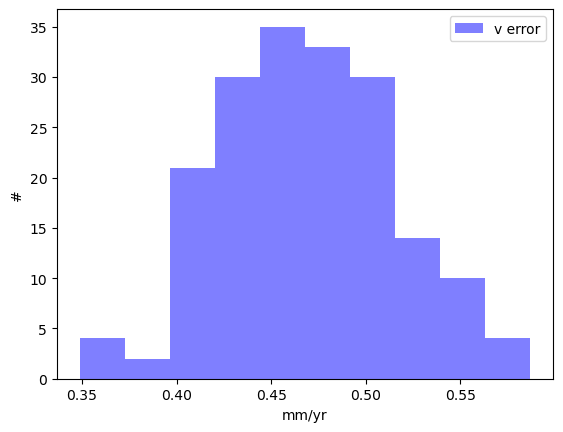

In [180]:
[signal_xy, signal_xy_error, 
 noise_xy, C_inv] = hvlsc.collocation.collocation_signal_known(
                                            np.atleast_2d(v).T, 
                                            CSS, CNN)

fig, ax = plt.subplots(1)
ax.hist(signal_xy_error, alpha=0.5, color='blue', label='v error')
ax.set_xlabel('mm/yr')
ax.set_ylabel('#')
ax.legend()

In [105]:
vertical_xy_error = signal_xy_error

In [106]:
comb_xy_error = np.hstack([horizontal_xy_error, vertical_xy_error])

In [107]:
comb_error_df = pd.DataFrame(comb_xy_error, columns=['ew', 'ns', 'v'])

In [142]:
comb_error_df

ew        ns         v
0    0.061411  0.080918  0.519313
1    0.055064  0.074474  0.437805
2    0.057327  0.074076  0.500650
3    0.055424  0.073929  0.408826
4    0.057110  0.073390  0.474734
..        ...       ...       ...
178  0.053396  0.070201  0.425844
179  0.055676  0.075388  0.458899
180  0.059262  0.085275  0.558885
181  0.053765  0.071008  0.382978
182  0.056074  0.069704  0.417348

[183 rows x 3 columns]

In [125]:
comb_error_df.to_csv('collocation_precision_midas_2015_2024.csv')

### Collocation at interpolation grid

In [181]:
# TODO do not support mov var on vertical, add it
grid_out, grid_error = collocation2grid(lon_gnss, lat_gnss,
                                        grid_lon, grid_lat,
                                        np.atleast_2d(v).T,
                                        C_inv,
                                        fparameters,
                                        movvar_parameters=[1, 150, None, 7],
                                        moving_variance=False,
                                        iteration_order=['v'])

Loop 1
Collocation at the interpolation points is done.


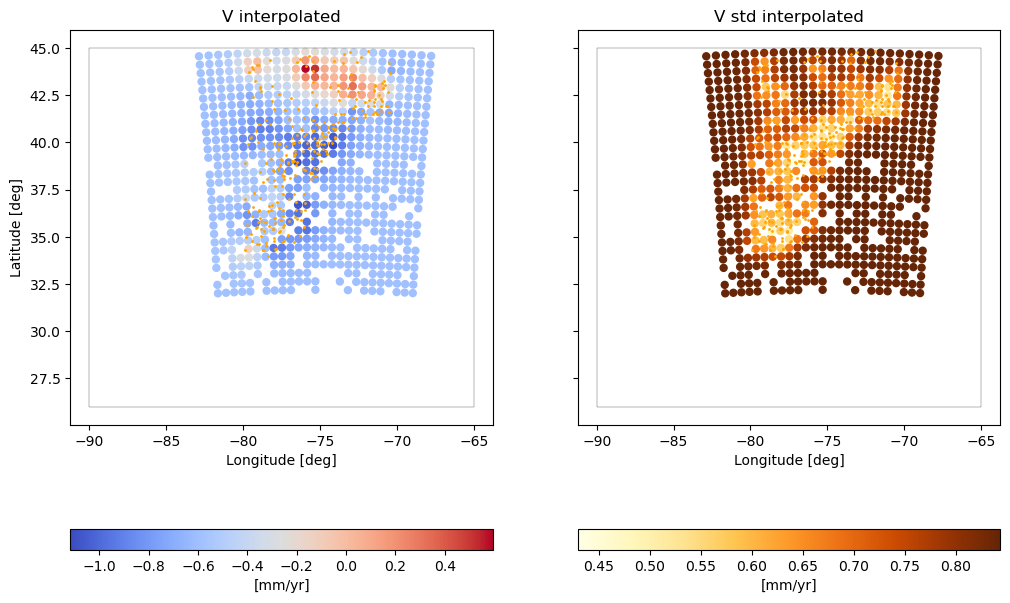

In [182]:
grid_lon = _filter_grid_points(mov_df,'grid').lon.values
grid_lat = _filter_grid_points(mov_df,'grid').lat.values

fig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)
im1=ax[0].scatter(grid_lon, grid_lat, s=25, marker='o', c=grid_out + mean_v, cmap='coolwarm')
im2=ax[1].scatter(grid_lon, grid_lat, s=25, marker='o', c=grid_error, cmap='YlOrBr')
[a.plot(gnss_df2.lon, gnss_df2.lat,'o', markersize=1, color='orange') for a in ax]
[fig.colorbar(im, ax=a, location='bottom', label='[mm/yr]') for im, a in zip([im1, im2], ax)]
[a.set_title(txt) for a, txt in zip(ax, ['V interpolated', 'V std interpolated'])]
plates.exterior.plot(ax=ax[0], color='black', linewidth=0.2)
plates.exterior.plot(ax=ax[1], color='black', linewidth=0.2)

ax[0].set_ylabel('Latitude [deg]'),
for a in ax: 
    #a.set_xlim([10, 80]), a.set_ylim([-25, 41])
    a.set_xlabel('Longitude [deg]')

In [184]:
# Restore mean and trends
#collocation_df['v'] = collocation_df['plate_up'] + np.squeeze(grid_out) + mean_v
collocation_df['v'] = np.squeeze(grid_out) + mean_v
collocation_df['sv'] = grid_error

# Results

Text(0.5, 1.0, 'LSC')

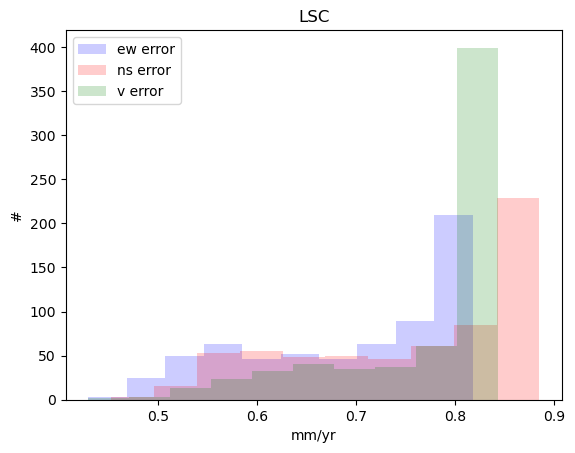

In [185]:
fig, ax = plt.subplots(1)
ax.hist(np.sqrt(collocation_df.sew), alpha=0.2, color='blue', label='ew error')
ax.hist(np.sqrt(collocation_df.sns), alpha=0.2, color='red', label='ns error')
ax.hist(collocation_df.sv, alpha=0.2, color='green', label='v error')
ax.set_xlabel('mm/yr')
ax.set_ylabel('#')
ax.legend()
ax.set_title('LSC')

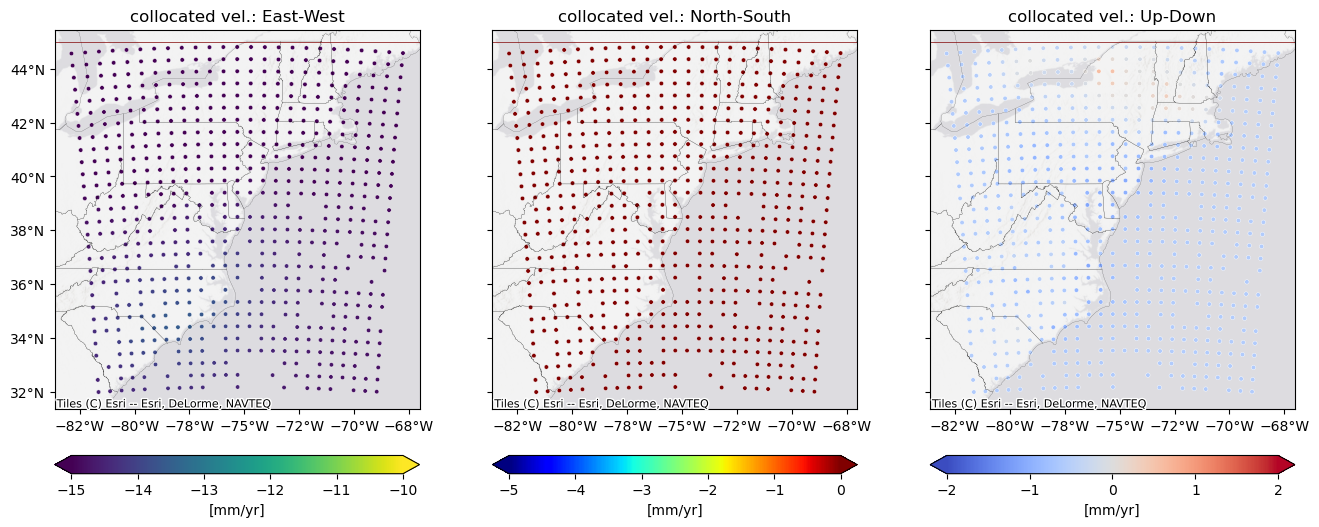

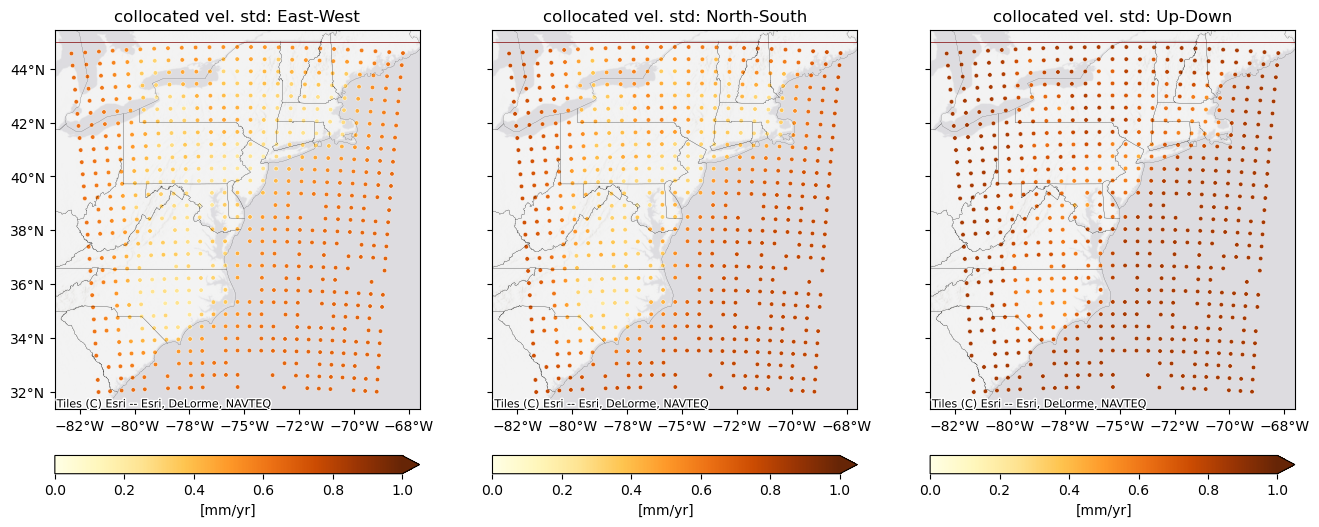

In [186]:
fig, ax  = _plot_gnss(collocation_df,
                prefix_title='collocated vel.:',
                column_list=['ew','ns','v'],
                cmap_list=['viridis', 'jet', 'coolwarm'],
                clim_list=[[-15, -10], [-5, 0], [-2, 2]], **aux)
for a in ax: plates.exterior.plot(ax=a, lw=0.5, marker='--', color='maroon')

fig, ax  = _plot_gnss(collocation_df,
                prefix_title='collocated vel. std:',
                column_list=['sew','sns','sv'],
                cmap_list=['YlOrBr', 'YlOrBr', 'YlOrBr'],
                clim_list=[[0, 1], [0, 1], [0, 1]],extend='max', **aux)
for a in ax: plates.exterior.plot(ax=a, lw=0.5, marker='--', color='maroon')

In [188]:
# Save
collocation_df.to_file('/u/duvel-d2/govorcin/NJ/ASC/GNSS/gnss_grid_30_midas_2000_2024')

# Krigging

In [115]:
import gstools as gs
model_ew = gs.Exponential(dim=2,  latlon=True, geo_scale=gs.KM_SCALE)
model_ns = gs.Exponential(dim=2,  latlon=True, geo_scale=gs.KM_SCALE)
model_v = gs.Exponential(dim=2,  latlon=True, geo_scale=gs.KM_SCALE)

In [116]:
# Use position adjusted for plate boundary > moved 1.5e3 km
lat = _filter_grid_points(mov_df,'sites').mov_lat.values
lon = _filter_grid_points(mov_df,'sites').mov_lon.values

# Use GNSS position
lon_gnss = _filter_grid_points(mov_df,'sites').lon.values
lat_gnss = _filter_grid_points(mov_df,'sites').lat.values

Exponential(latlon=True, var=1.66e+06, len_scale=9.94e+08, nugget=0.0, geo_scale=6.37e+03)
Exponential(latlon=True, var=2e+04, len_scale=9.07e+06, nugget=0.0, geo_scale=6.37e+03)
Exponential(latlon=True, var=2e+04, len_scale=9.07e+06, nugget=0.0, geo_scale=6.37e+03)


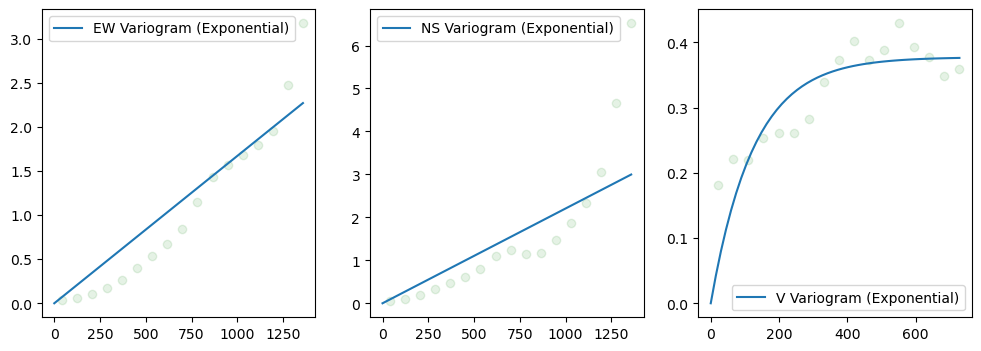

In [157]:
# Mean
df = _filter_grid_points(mov_df,'sites')
kmean_ew = np.nanmean(df.e) 
kmean_ns = np.nanmean(df.n) 
kmean_v = np.nanmean(df.v) 

# Data
ew = df.e - kmean_ew 
ns = df.n - kmean_ns
v = df.v - kmean_v 
se = df.se
sn = df.sn
sv = df.sv

# Init models
models = [model_ew, model_ns]#, model_v]
disp = [ew, ns]#, v]
disp_std = [se, sn]#, sv]

# Horizontal
bin_centers = []
gammas = []
for model, vals in zip(models, disp):
    bin_center, gamma = gs.vario_estimate((lat, lon), 
                                          vals, 
                                          latlon=True,
                                          geo_scale=gs.KM_SCALE,
                                          max_dist=1400)
    bin_centers.append(bin_center)
    gammas.append(gamma)
    model.fit_variogram(bin_center, gamma, nugget=False)
    print(model)

# Vertical
bin_center, gamma = gs.vario_estimate((lat, lon), 
                                          v, 
                                          latlon=True,
                                          geo_scale=gs.KM_SCALE,
                                          max_dist=750)
bin_centers.append(bin_center)
gammas.append(gamma)
model_v.fit_variogram(bin_center, gamma, nugget=False)
print(model)

# Combine model outputs
models = [model_ew, model_ns, model_v]
disp = [ew, ns, v]
disp_std = [se, sn, sv]

#Plot
fig, ax = plt.subplots(1,3, figsize=(12,4))
model_ew.plot(x_max=max(bin_centers[0]), ax=ax[0], label=f'EW Variogram ({model_ew.name})')
model_ns.plot(x_max=max(bin_centers[1]), ax=ax[1], label=f'NS Variogram ({model_ns.name})')
model_v.plot(x_max=max(bin_centers[2]), ax=ax[2], label=f'V Variogram ({model_v.name})')
for ix, a in enumerate(ax):
    a.scatter(bin_centers[ix], gammas[ix], alpha=.1, color='green')


In [158]:
fields, stds = [], []
df = _filter_grid_points(mov_df,'grid')

for model, val, std in zip(models, disp, disp_std):


    krig = gs.krige.Ordinary(model=model,
                             cond_pos=(lat, lon),
                             cond_val=val,
                             exact=False,
                             cond_err=std,
                             fit_variogram=False)
    
    krig.set_pos((df.mov_lat.values,
                  df.mov_lon.values), 
                  mesh_type="unstructured")
    field, var = krig(return_var=True)
    fields.append(field)
    stds.append(np.sqrt(var))


grid_lat1 = df.lat.values
grid_lon1 = df.lon.values
krige_grid_df = gpd.GeoDataFrame([],
                           geometry = gpd.points_from_xy(grid_lon1,
                                                         grid_lat1),
                           crs='EPSG:4326')

# Get plate motion
krige_grid_df['plate'] = None
for _, plate in plates.iterrows():
    ix = krige_grid_df[krige_grid_df.within(plate.geometry)].index
    krige_grid_df.loc[ix, 'plate'] = plate.Code

print(f'GNSS sites cover: {list(krige_grid_df.plate.unique())} plates')

krige_grid_df['lon'] = krige_grid_df.geometry.apply(lambda x: x.xy[0][0])
krige_grid_df['lat'] = krige_grid_df.geometry.apply(lambda x: x.xy[1][0])

GNSS sites cover: ['NA'] plates


In [154]:
# Restore trend assoicated with plate motion
option=1
if option==1:
    # Option 1: Relative to North America
    plate_omegas = plate_motion[plate_motion.code == code2itrf['NA']]
    print('NA', plate_omegas)

    plate_v = predict_plate_motion(krige_grid_df.lon.values, 
                                krige_grid_df.lat.values,
                                plate_omegas.omega_x, 
                                plate_omegas.omega_y, 
                                plate_omegas.omega_z)
                    
    krige_grid_df['plate_ew'] = np.float64(plate_v)[:,0]
    krige_grid_df['plate_ns'] = np.float64(plate_v)[:,1]
    krige_grid_df['plate_up'] = np.float64(plate_v)[:,2]

elif option==2:
    # Option 2. Remove both NORTH AMERICA & PACIFIC plate motion
    for p in ['NA', 'PA']:
        plate_grid = krige_grid_df[krige_grid_df.plate == p]
        plate_omegas = plate_motion[plate_motion.code == code2itrf[p]]
        print(p, plate_omegas)

        plate_v = predict_plate_motion(plate_grid.lon.values, 
                                    plate_grid.lat.values,
                                    plate_omegas.omega_x, 
                                    plate_omegas.omega_y, 
                                    plate_omegas.omega_z)
                        
        krige_grid_df.loc[krige_grid_df.plate == p,
                ['plate_ew', 'plate_ns', 'plate_up']] = np.float64(plate_v)
else:
    krige_grid_df['plate_ew'] = np.zeros_like(krige_grid_df.ew.values)
    krige_grid_df['plate_ns'] = np.zeros_like(krige_grid_df.ew.values) 
    krige_grid_df['plate_up'] = np.zeros_like(krige_grid_df.ew.values)

NA    code  omega_x  omega_y  omega_z
6  NOAM   0.0066  -0.1928  -0.0176


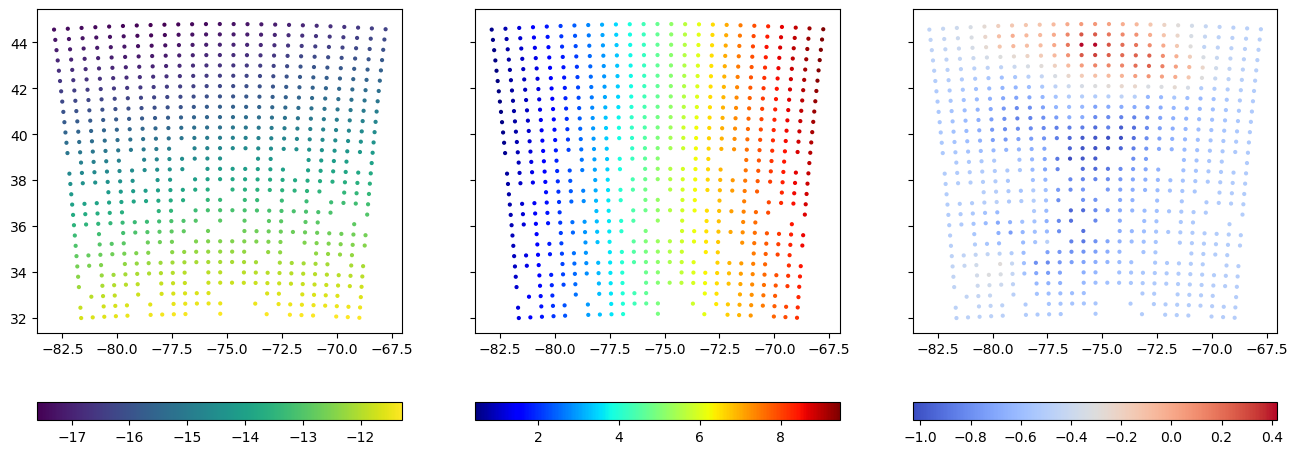

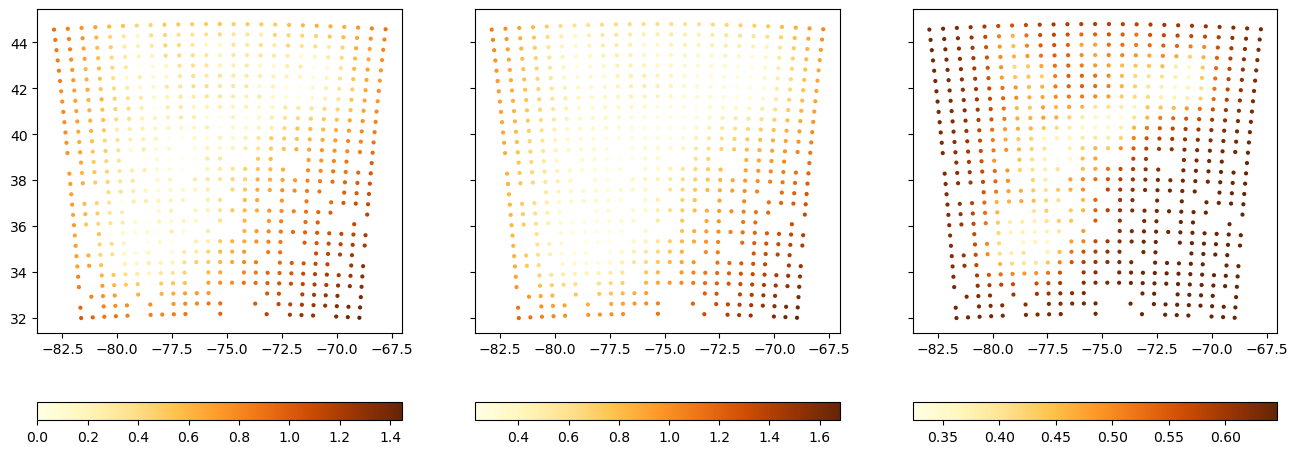

In [155]:
# Kriging give weird values for vertical disp interpolation
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,6))

im1 = ax[0].scatter(grid_lon1, grid_lat1, 4, fields[0] + krige_grid_df['plate_ew']  ,cmap="viridis") #+ kmean_ew 
im2 = ax[1].scatter(grid_lon1, grid_lat1, 4, fields[1] + krige_grid_df['plate_ns'] ,cmap="jet")#+ kmean_ns
im3 = ax[2].scatter(grid_lon1, grid_lat1, 4, fields[2] + kmean_v, cmap="coolwarm")

for a, im in zip(ax, [im1, im2,im3]): 
    fig.colorbar(im, ax=a, location='bottom')


fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,6))
im1 = ax[0].scatter(grid_lon1, grid_lat1, 4, stds[0],cmap="YlOrBr")
im2 = ax[1].scatter(grid_lon1, grid_lat1, 4, stds[1],cmap="YlOrBr")
im3 = ax[2].scatter(grid_lon1, grid_lat1, 4, stds[2],cmap="YlOrBr")

for a, im in zip(ax, [im1, im2,im3]): 
    fig.colorbar(im, ax=a, location='bottom')

## Comparison LSC and Krigging

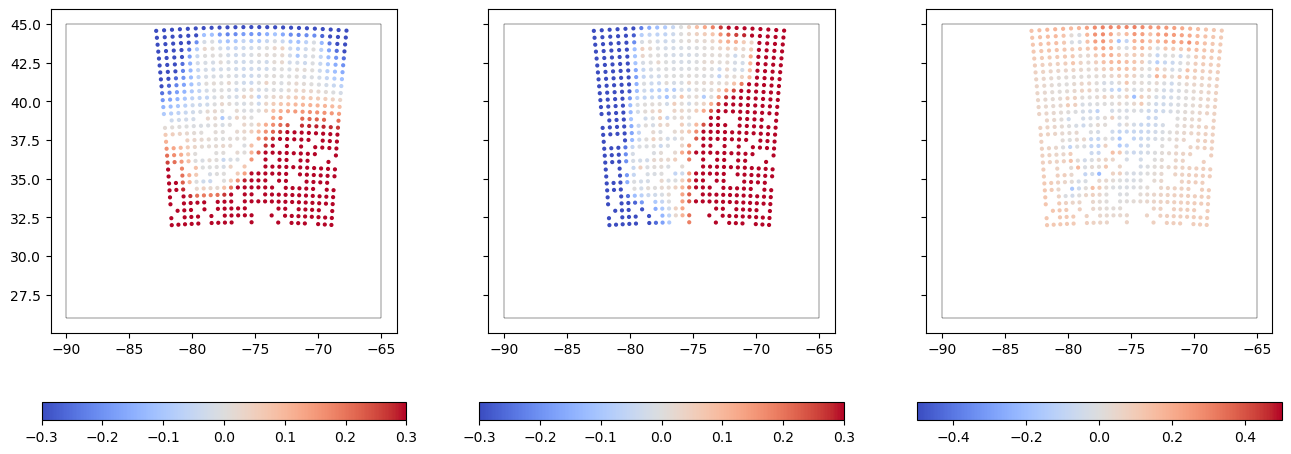

In [187]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,6))

im1 = ax[0].scatter(grid_lon1, grid_lat1, 4, (fields[0]+ kmean_ew) - collocation_df.ew , cmap="coolwarm", clim=[-0.3,0.3])
im2 = ax[1].scatter(grid_lon1, grid_lat1, 4, (fields[1]+ kmean_ns) - collocation_df.ns ,cmap="coolwarm", clim=[-0.3,0.3])
im3 = ax[2].scatter(grid_lon1, grid_lat1, 4, (fields[2] + kmean_v) - collocation_df.v, cmap="coolwarm", clim=[-0.5,0.5])

for a, im in zip(ax, [im1, im2,im3]):
    plates.exterior.plot(ax=a, lw=0.3, color='black')
    fig.colorbar(im, ax=a, location='bottom')